# Wind Curtailment Prediction (Hill of Towie, Scotland)

Period: 09/2023 - 08/2024
1. Data Preparation
2. Data Analysis
3. Feature Engineering
4. Data Splitting
5. Model Training
6. Model Testing (Evaluation)
7. Model Analysis

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Data Preparation

**Input:** <br>
SCADA data, ERA5 data, NESO data <br>
**Process:** <br>
data filter, data transformation, data merging <br>
**Output:** <br>
1 final dataset for Wind Curtailment Classification

### a. Curtailment based on NESO BOA (Bid-Offer Acceptance for reducing/increasing power generation)

**Input:** <br>
1) NESO BOA Volume <br>
boa_data_2023_24.csv & boa_data_2024_25.csv
2) SCADA Shutdown Duration <br>
ShutdownDuration.csv

**Process:** <br>

Handling NESO BOA Volume
1. Merge 2 files of BOA volume into 1 dataset
2. Filter in one-year period 01092023 - 31082024, also select only Hill of Towie   
3. SUM Aggregation, from daily per 30 minutes to be daily per 1 hour

Handling SCADA Shutdown Duration
1. Filter in one-year period 01092023 - 31082024
2. SUM Aggregation, from daily per 10 minutes to be daily per 1 hour
3. SUM Aggregation, from 21 turbines into 1 whole wind farm <br>
so each 1-hour timestamp is unique per data row

Generate CURTAILMENT Label
1. Merge BOA Volume dataset & SCADA shutdown duration, on same 1-hour timestamp
2. Create Curtailment feature with binary value, with condition:
- 1, IF (negative BOA volume) OR (any minutes recorded in shutdown duration)
- 0, otherwise

Note:
- negative BOA volume means request to decrease power generation
- postive BOA volume means request to increase power generation
- zero BOA volume means no instruction

Note:
- any minutes recorded in shutdown duration means turbine being shut down
- zero means no shut down

**Output:** <br>
HTW_shutdown_duration_windfarm_1hr.csv <br>
HTW_boa_request_windfarm_1hr.csv <br>
HTW_curtailment_label.csv

In [ ]:
boa_htw_df = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/boa_data_2023_24.csv")
print(len(boa_htw_df))
boa_htw_df = pd.concat([boa_htw_df, pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/boa_data_2024_25.csv")])
print(len(boa_htw_df))

171952
423248


In [ ]:
boa_htw_df = boa_htw_df[boa_htw_df["Generator_Full_Name"] == "Hill of Towie"]
boa_htw_df["Date"] = pd.to_datetime(boa_htw_df["Date"])

# boa_htw_df["Timestamp"] = pd.to_datetime(boa_htw_df["Date"], utc=True)

start_date = "2023-09-01"
end_date   = "2024-08-31"
boa_htw_df = boa_htw_df[
    boa_htw_df["Date"].between(start_date, end_date, inclusive="both")
]

In [ ]:
boa_htw_df["Date"].min(), boa_htw_df["Date"].max(), len(boa_htw_df)

(Timestamp('2023-09-03 00:00:00'), Timestamp('2024-08-27 00:00:00'), 429)

In [ ]:
boa_htw_df.head()

,Date,Settlement_Period,Generator_Name,Generator_Full_Name,BOA_Volume
50682,2023-09-03,29,HLTWW-1,Hill of Towie,-4.9
50720,2023-09-03,30,HLTWW-1,Hill of Towie,-22.0
50758,2023-09-03,31,HLTWW-1,Hill of Towie,-22.0
50796,2023-09-03,32,HLTWW-1,Hill of Towie,-23.0
50834,2023-09-03,33,HLTWW-1,Hill of Towie,-21.0


In [ ]:
start_date = "2023-09-01"
end_date   = "2024-08-31"
dates = pd.date_range(start=start_date, end=end_date, freq="D")
settlement_periods = range(1, 49)

dates_df = pd.MultiIndex.from_product(
    [dates, settlement_periods],
    names=["Date", "Settlement_Period"]
).to_frame(index=False)

dates_df["Timestamp"] = (
    dates_df["Date"]
    + pd.to_timedelta((dates_df["Settlement_Period"] - 1) * 30, unit="min")
)
dates_df["Timestamp"] = pd.to_datetime(dates_df["Timestamp"], utc=True)

dates_df.head()

,Date,Settlement_Period,Timestamp
0,2023-09-01,1,2023-09-01 00:00:00+00:00
1,2023-09-01,2,2023-09-01 00:30:00+00:00
2,2023-09-01,3,2023-09-01 01:00:00+00:00
3,2023-09-01,4,2023-09-01 01:30:00+00:00
4,2023-09-01,5,2023-09-01 02:00:00+00:00


In [ ]:
dates_df[dates_df["Date"] == "2023-09-01"]

,Date,Settlement_Period,Timestamp
0,2023-09-01,1,2023-09-01 00:00:00+00:00
1,2023-09-01,2,2023-09-01 00:30:00+00:00
2,2023-09-01,3,2023-09-01 01:00:00+00:00
3,2023-09-01,4,2023-09-01 01:30:00+00:00
4,2023-09-01,5,2023-09-01 02:00:00+00:00
5,2023-09-01,6,2023-09-01 02:30:00+00:00
6,2023-09-01,7,2023-09-01 03:00:00+00:00
7,2023-09-01,8,2023-09-01 03:30:00+00:00
8,2023-09-01,9,2023-09-01 04:00:00+00:00
9,2023-09-01,10,2023-09-01 04:30:00+00:00


In [ ]:
boa_htw_dates_df = dates_df.merge(boa_htw_df, on=["Date", "Settlement_Period"], how="left")
boa_htw_dates_df["Generator_Name"] = "HLTWW-1"
boa_htw_dates_df["Generator_Full_Name"] = "Hill of Towie"
# curtailment_htw_df["Curtailment"] = [1 if x<0 else 0 for x in curtailment_htw_df["BOA_Volume"]]
# boa_htw_dates_df = boa_htw_dates_df.drop(["Date_x", "Date_y"], axis=1)
boa_htw_dates_df.fillna(0, inplace=True)
boa_htw_dates_df.head()

,Date,Settlement_Period,Timestamp,Generator_Name,Generator_Full_Name,BOA_Volume
0,2023-09-01,1,2023-09-01 00:00:00+00:00,HLTWW-1,Hill of Towie,0.0
1,2023-09-01,2,2023-09-01 00:30:00+00:00,HLTWW-1,Hill of Towie,0.0
2,2023-09-01,3,2023-09-01 01:00:00+00:00,HLTWW-1,Hill of Towie,0.0
3,2023-09-01,4,2023-09-01 01:30:00+00:00,HLTWW-1,Hill of Towie,0.0
4,2023-09-01,5,2023-09-01 02:00:00+00:00,HLTWW-1,Hill of Towie,0.0


In [ ]:
boa_htw_dates_df[boa_htw_dates_df["BOA_Volume"]<0]

,Date,Settlement_Period,Timestamp,Generator_Name,Generator_Full_Name,BOA_Volume
124,2023-09-03,29,2023-09-03 14:00:00+00:00,HLTWW-1,Hill of Towie,-4.900
125,2023-09-03,30,2023-09-03 14:30:00+00:00,HLTWW-1,Hill of Towie,-22.000
126,2023-09-03,31,2023-09-03 15:00:00+00:00,HLTWW-1,Hill of Towie,-22.000
127,2023-09-03,32,2023-09-03 15:30:00+00:00,HLTWW-1,Hill of Towie,-23.000
128,2023-09-03,33,2023-09-03 16:00:00+00:00,HLTWW-1,Hill of Towie,-21.000
...,...,...,...,...,...,...
17360,2024-08-27,33,2024-08-27 16:00:00+00:00,HLTWW-1,Hill of Towie,-21.000
17361,2024-08-27,34,2024-08-27 16:30:00+00:00,HLTWW-1,Hill of Towie,-21.000
17362,2024-08-27,35,2024-08-27 17:00:00+00:00,HLTWW-1,Hill of Towie,-17.000
17363,2024-08-27,36,2024-08-27 17:30:00+00:00,HLTWW-1,Hill of Towie,-16.000


In [ ]:
boa_htw_dates_df["Timestamp"] = pd.to_datetime(boa_htw_dates_df["Timestamp"],utc=True)
boa_htw_dates_df["Hour"] = boa_htw_dates_df["Timestamp"].dt.floor("h")
boa_htw_dates_df.head()

,Date,Settlement_Period,Timestamp,Generator_Name,Generator_Full_Name,BOA_Volume,Hour
0,2023-09-01,1,2023-09-01 00:00:00+00:00,HLTWW-1,Hill of Towie,0.0,2023-09-01 00:00:00+00:00
1,2023-09-01,2,2023-09-01 00:30:00+00:00,HLTWW-1,Hill of Towie,0.0,2023-09-01 00:00:00+00:00
2,2023-09-01,3,2023-09-01 01:00:00+00:00,HLTWW-1,Hill of Towie,0.0,2023-09-01 01:00:00+00:00
3,2023-09-01,4,2023-09-01 01:30:00+00:00,HLTWW-1,Hill of Towie,0.0,2023-09-01 01:00:00+00:00
4,2023-09-01,5,2023-09-01 02:00:00+00:00,HLTWW-1,Hill of Towie,0.0,2023-09-01 02:00:00+00:00


In [ ]:
boa_hourly_df = (
    boa_htw_dates_df
    .groupby(
        ["Date", "Hour", "Generator_Name", "Generator_Full_Name"],
        as_index=False
    )
    .agg(
        BOA_Volume_hour=("BOA_Volume", "sum")
    )
)
boa_hourly_df.rename(columns={"Hour":"Timestamp"}, inplace=True)
boa_hourly_df.head()

,Date,Timestamp,Generator_Name,Generator_Full_Name,BOA_Volume_hour
0,2023-09-01,2023-09-01 00:00:00+00:00,HLTWW-1,Hill of Towie,0.0
1,2023-09-01,2023-09-01 01:00:00+00:00,HLTWW-1,Hill of Towie,0.0
2,2023-09-01,2023-09-01 02:00:00+00:00,HLTWW-1,Hill of Towie,0.0
3,2023-09-01,2023-09-01 03:00:00+00:00,HLTWW-1,Hill of Towie,0.0
4,2023-09-01,2023-09-01 04:00:00+00:00,HLTWW-1,Hill of Towie,0.0


In [ ]:
shutdown_df = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/ShutdownDuration.csv")
shutdown_df.info()

# Parse timestamp UTC-aware
shutdown_df["TimeStamp_StartFormat"] = pd.to_datetime(
    shutdown_df["TimeStamp_StartFormat"],
    utc=True
)

# Floor to 60-minute bins
shutdown_df["SP_Timestamp"] = shutdown_df["TimeStamp_StartFormat"].dt.floor("60min")

# Aggregate per turbine per 60 minutes
shutdown_60min_turbine = (
    shutdown_df
    .groupby(["SP_Timestamp", "TurbineName"], as_index=False)
    .agg(ShutdownDuration_1hr=("ShutdownDuration", "sum"))
)

# Optional: create "Hour_Index" within the day (1..24)
shutdown_60min_turbine["Hour_Index"] = (
    shutdown_60min_turbine["SP_Timestamp"].dt.hour + 1
).astype(int)

# Binary shutdown flag per turbine per hour
shutdown_60min_turbine["shutdown_flag"] = (
    shutdown_60min_turbine["ShutdownDuration_1hr"] > 0
).astype(int)

# Sanity check
print("Max possible per turbine per 60min should be 3600 seconds:")
print("max ShutdownDuration_1hr =", shutdown_60min_turbine["ShutdownDuration_1hr"].max())

shutdown_60min_turbine.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9574005 entries, 0 to 9574004
Data columns (total 3 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   TimeStamp_StartFormat  object
 1   TurbineName            object
 2   ShutdownDuration       int64 
dtypes: int64(1), object(2)
memory usage: 219.1+ MB
Max possible per turbine per 60min should be 3600 seconds:
max ShutdownDuration_1hr = 3600


,SP_Timestamp,TurbineName,ShutdownDuration_1hr,Hour_Index,shutdown_flag
0,2016-01-01 00:00:00+00:00,T01,0,1,0
1,2016-01-01 00:00:00+00:00,T02,0,1,0
2,2016-01-01 00:00:00+00:00,T03,0,1,0
3,2016-01-01 00:00:00+00:00,T04,0,1,0
4,2016-01-01 00:00:00+00:00,T05,0,1,0


In [ ]:
print("\nExample rows:")
display(shutdown_60min_turbine.head(50))


Example rows:


,SP_Timestamp,TurbineName,ShutdownDuration_1hr,Hour_Index,shutdown_flag
0,2016-01-01 00:00:00+00:00,T01,0,1,0
1,2016-01-01 00:00:00+00:00,T02,0,1,0
2,2016-01-01 00:00:00+00:00,T03,0,1,0
3,2016-01-01 00:00:00+00:00,T04,0,1,0
4,2016-01-01 00:00:00+00:00,T05,0,1,0
5,2016-01-01 00:00:00+00:00,T06,3600,1,1
6,2016-01-01 00:00:00+00:00,T07,0,1,0
7,2016-01-01 00:00:00+00:00,T08,0,1,0
8,2016-01-01 00:00:00+00:00,T09,0,1,0
9,2016-01-01 00:00:00+00:00,T10,0,1,0


In [ ]:
# Define range
start = pd.Timestamp("2023-09-01 00:00:00", tz="UTC")
end   = pd.Timestamp("2024-09-01 00:00:00", tz="UTC")  # end-exclusive

# Filter
shutdown_60min_turbine_2324 = shutdown_60min_turbine.loc[
    (shutdown_60min_turbine["SP_Timestamp"] >= start) &
    (shutdown_60min_turbine["SP_Timestamp"] < end)
].copy()

shutdown_60min_turbine_2324.head()

,SP_Timestamp,TurbineName,ShutdownDuration_1hr,Hour_Index,shutdown_flag
1411200,2023-09-01 00:00:00+00:00,T01,0,1,0
1411201,2023-09-01 00:00:00+00:00,T02,0,1,0
1411202,2023-09-01 00:00:00+00:00,T03,0,1,0
1411203,2023-09-01 00:00:00+00:00,T04,0,1,0
1411204,2023-09-01 00:00:00+00:00,T05,0,1,0


In [ ]:
shutdown_60min_farm_2324 = (
    shutdown_60min_turbine_2324
    .groupby("SP_Timestamp", as_index=False)
    .agg(
        ShutdownDuration_1hr=("ShutdownDuration_1hr", "sum"),
        turbines_down=("shutdown_flag", "sum")
    )
)
shutdown_60min_farm_2324["Date"] = shutdown_60min_farm_2324["SP_Timestamp"].dt.floor("D")
shutdown_60min_farm_2324["Settlement_Period"] = (
    ((shutdown_60min_farm_2324["SP_Timestamp"].dt.hour * 60
      + shutdown_60min_farm_2324["SP_Timestamp"].dt.minute) // 30) + 1
).astype(int)
shutdown_60min_farm_2324["farm_shutdown_flag"] = (
    shutdown_60min_farm_2324["ShutdownDuration_1hr"] > 0
).astype(int)
shutdown_60min_farm_2324 = shutdown_60min_farm_2324[
    ["SP_Timestamp", "Date", "Settlement_Period",
     "ShutdownDuration_1hr", "farm_shutdown_flag"]
]

In [ ]:
shutdown_60min_farm_2324.head()

,SP_Timestamp,Date,Settlement_Period,ShutdownDuration_1hr,farm_shutdown_flag
0,2023-09-01 00:00:00+00:00,2023-09-01 00:00:00+00:00,1,0,0
1,2023-09-01 01:00:00+00:00,2023-09-01 00:00:00+00:00,3,194,1
2,2023-09-01 02:00:00+00:00,2023-09-01 00:00:00+00:00,5,0,0
3,2023-09-01 03:00:00+00:00,2023-09-01 00:00:00+00:00,7,0,0
4,2023-09-01 04:00:00+00:00,2023-09-01 00:00:00+00:00,9,0,0


In [ ]:
shutdown_60min_farm_2324["farm_shutdown_flag"].value_counts()

,count
farm_shutdown_flag,
1,5345
0,3439


In [ ]:
boa_hourly_df.head()

,Date,Timestamp,Generator_Name,Generator_Full_Name,BOA_Volume_hour
0,2023-09-01,2023-09-01 00:00:00+00:00,HLTWW-1,Hill of Towie,0.0
1,2023-09-01,2023-09-01 01:00:00+00:00,HLTWW-1,Hill of Towie,0.0
2,2023-09-01,2023-09-01 02:00:00+00:00,HLTWW-1,Hill of Towie,0.0
3,2023-09-01,2023-09-01 03:00:00+00:00,HLTWW-1,Hill of Towie,0.0
4,2023-09-01,2023-09-01 04:00:00+00:00,HLTWW-1,Hill of Towie,0.0


In [ ]:
boa_hourly_df[boa_hourly_df["BOA_Volume_hour"]<0]

,Date,Timestamp,Generator_Name,Generator_Full_Name,BOA_Volume_hour
62,2023-09-03,2023-09-03 14:00:00+00:00,HLTWW-1,Hill of Towie,-26.900
63,2023-09-03,2023-09-03 15:00:00+00:00,HLTWW-1,Hill of Towie,-45.000
64,2023-09-03,2023-09-03 16:00:00+00:00,HLTWW-1,Hill of Towie,-40.400
65,2023-09-03,2023-09-03 17:00:00+00:00,HLTWW-1,Hill of Towie,-3.266
474,2023-09-20,2023-09-20 18:00:00+00:00,HLTWW-1,Hill of Towie,-42.350
...,...,...,...,...,...
8678,2024-08-27,2024-08-27 14:00:00+00:00,HLTWW-1,Hill of Towie,-45.000
8679,2024-08-27,2024-08-27 15:00:00+00:00,HLTWW-1,Hill of Towie,-46.000
8680,2024-08-27,2024-08-27 16:00:00+00:00,HLTWW-1,Hill of Towie,-42.000
8681,2024-08-27,2024-08-27 17:00:00+00:00,HLTWW-1,Hill of Towie,-33.000


In [ ]:
boa_hourly_df[boa_hourly_df["BOA_Volume_hour"]>0]

,Date,Timestamp,Generator_Name,Generator_Full_Name,BOA_Volume_hour


In [ ]:
boa_hourly_df[boa_hourly_df["BOA_Volume_hour"]==0]

,Date,Timestamp,Generator_Name,Generator_Full_Name,BOA_Volume_hour
0,2023-09-01,2023-09-01 00:00:00+00:00,HLTWW-1,Hill of Towie,0.0
1,2023-09-01,2023-09-01 01:00:00+00:00,HLTWW-1,Hill of Towie,0.0
2,2023-09-01,2023-09-01 02:00:00+00:00,HLTWW-1,Hill of Towie,0.0
3,2023-09-01,2023-09-01 03:00:00+00:00,HLTWW-1,Hill of Towie,0.0
4,2023-09-01,2023-09-01 04:00:00+00:00,HLTWW-1,Hill of Towie,0.0
...,...,...,...,...,...
8779,2024-08-31,2024-08-31 19:00:00+00:00,HLTWW-1,Hill of Towie,0.0
8780,2024-08-31,2024-08-31 20:00:00+00:00,HLTWW-1,Hill of Towie,0.0
8781,2024-08-31,2024-08-31 21:00:00+00:00,HLTWW-1,Hill of Towie,0.0
8782,2024-08-31,2024-08-31 22:00:00+00:00,HLTWW-1,Hill of Towie,0.0


In [ ]:
shutdown_60min_farm_2324.head()

,SP_Timestamp,Date,Settlement_Period,ShutdownDuration_1hr,farm_shutdown_flag
0,2023-09-01 00:00:00+00:00,2023-09-01 00:00:00+00:00,1,0,0
1,2023-09-01 01:00:00+00:00,2023-09-01 00:00:00+00:00,3,194,1
2,2023-09-01 02:00:00+00:00,2023-09-01 00:00:00+00:00,5,0,0
3,2023-09-01 03:00:00+00:00,2023-09-01 00:00:00+00:00,7,0,0
4,2023-09-01 04:00:00+00:00,2023-09-01 00:00:00+00:00,9,0,0


In [ ]:
curtailment_label_df = boa_hourly_df.merge(shutdown_60min_farm_2324, left_on="Timestamp", right_on="SP_Timestamp")
curtailment_label_df.drop(["SP_Timestamp","Date_y","Date_x"], axis=1, inplace=True)
curtailment_label_df.rename(columns={"Settlement_Period_x":"Settlement_Period"}, inplace=True)
curtailment_label_df.head()

,Timestamp,Generator_Name,Generator_Full_Name,BOA_Volume_hour,Settlement_Period,ShutdownDuration_1hr,farm_shutdown_flag
0,2023-09-01 00:00:00+00:00,HLTWW-1,Hill of Towie,0.0,1,0,0
1,2023-09-01 01:00:00+00:00,HLTWW-1,Hill of Towie,0.0,3,194,1
2,2023-09-01 02:00:00+00:00,HLTWW-1,Hill of Towie,0.0,5,0,0
3,2023-09-01 03:00:00+00:00,HLTWW-1,Hill of Towie,0.0,7,0,0
4,2023-09-01 04:00:00+00:00,HLTWW-1,Hill of Towie,0.0,9,0,0


In [ ]:
curtailment_label_df["Curtailment"] = (
    (curtailment_label_df["BOA_Volume_hour"] < 0) | (curtailment_label_df["farm_shutdown_flag"] == 1)
).astype(int)
curtailment_label_df.head()

,Timestamp,Generator_Name,Generator_Full_Name,BOA_Volume_hour,Settlement_Period,ShutdownDuration_1hr,farm_shutdown_flag,Curtailment
0,2023-09-01 00:00:00+00:00,HLTWW-1,Hill of Towie,0.0,1,0,0,0
1,2023-09-01 01:00:00+00:00,HLTWW-1,Hill of Towie,0.0,3,194,1,1
2,2023-09-01 02:00:00+00:00,HLTWW-1,Hill of Towie,0.0,5,0,0,0
3,2023-09-01 03:00:00+00:00,HLTWW-1,Hill of Towie,0.0,7,0,0,0
4,2023-09-01 04:00:00+00:00,HLTWW-1,Hill of Towie,0.0,9,0,0,0


In [ ]:
curtailment_label_df["Curtailment"].value_counts()

,count
Curtailment,
1,5452
0,3332


In [ ]:
curtailment_label_df.to_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/HTW_curtailment_label.csv", index=False)

In [ ]:
shutdown_60min_farm_2324.to_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/HTW_shutdown_duration_windfarm_1hr.csv", index=False)

In [ ]:
boa_hourly_df.to_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/HTW_boa_request_windfarm_1hr.csv", index=False)

### b. SCADA

**Input:** <br>
5 tables of SCADA on selected one-year period (12 months):
1) tblDailySummary 092023 - 082024 (12 csv files)
2) tblSCTurFlag 092023 - 082024 (12 csv files)
3) tblSCTurGrid 092023 - 082024 (12 csv files)
4) tblSCTurTemp 092023 - 082024 (12 csv files)
5) tblSCTurbine 092023 - 082024 (12 csv files)

**Process:** <br>
1) Per each table of turbine information, merge 12 files into 1 dataset <br>
with pre-selected features, based on relationship to Wind Power Generation
2) SUM or MEAN Aggregation of data records, <br>
also from daily per 10 minutes to be daily per 1 hour
3) Merge ALL those 5 datasets, into 1 dataset, on same timestamp
to be daily 1-hour, unique per data row

**Output:** <br>
- HTW_SCADA_perTurbine.csv
- HTW_farm_1hr.csv

In [ ]:
print("tabel: tblSCTurFlag (Turbine Flag Status)")
flag_23_09 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurFlag/tblSCTurFlag_2023_09.csv")
flag_23_10 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurFlag/tblSCTurFlag_2023_10.csv")
flag_23_11 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurFlag/tblSCTurFlag_2023_11.csv")
flag_23_12 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurFlag/tblSCTurFlag_2023_12.csv")
flag_24_01 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurFlag/tblSCTurFlag_2024_01.csv")
flag_24_02 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurFlag/tblSCTurFlag_2024_02.csv")
flag_24_03 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurFlag/tblSCTurFlag_2024_03.csv")
flag_24_04 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurFlag/tblSCTurFlag_2024_04.csv")
flag_24_05 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurFlag/tblSCTurFlag_2024_05.csv")
flag_24_06 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurFlag/tblSCTurFlag_2024_06.csv")
flag_24_07 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurFlag/tblSCTurFlag_2024_07.csv")
flag_24_08 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurFlag/tblSCTurFlag_2024_08.csv")
turflag_df = pd.concat([flag_23_09, flag_23_10, flag_23_11, flag_23_12, flag_24_01, flag_24_02, flag_24_03, flag_24_04, flag_24_05, flag_24_06, flag_24_07, flag_24_08])
turflag_df.head()

tabel: tblSCTurFlag (Turbine Flag Status)


,TimeStamp,StationId,wtc_ScYawOpe_counts,wtc_ScYawOpe_endvalue,wtc_ScYawUnw_counts,wtc_ScYawUnw_endvalue,wtc_PriAnAct_endvalue,wtc_ScAStart_counts,wtc_ScAStart_endvalue,wtc_ScBrakOp_counts,...,wtc_ScGrdSto_endvalue,wtc_ScGrdSto_timeon,wtc_LocRemSt_endvalue,wtc_AlarmCde_endvalue,wtc_BrakStat_endvalue,wtc_GenStat_endvalue,wtc_Turbstat_endvalue,wtc_YawStat_endvalue,wtc_TlcStat_endvalue,wtc_TlcStat_timeon
0,2023-09-01 00:00:00,2304510,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,=,*,t,|,0.0,0.0
1,2023-09-01 00:00:00,2304511,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,=,*,*,|,0.0,0.0
2,2023-09-01 00:00:00,2304512,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,=,G,b,|,0.0,0.0
3,2023-09-01 00:00:00,2304513,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,=,*,t,|,0.0,0.0
4,2023-09-01 00:00:00,2304514,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,=,*,t,|,0.0,0.0


In [ ]:
print("tabel: tblSCTurGrid (Turbine Grid sensor)")
grid_23_09 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurGrid/tblSCTurGrid_2023_09.csv")
grid_23_10 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurGrid/tblSCTurGrid_2023_10.csv")
grid_23_11 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurGrid/tblSCTurGrid_2023_11.csv")
grid_23_12 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurGrid/tblSCTurGrid_2023_12.csv")
grid_24_01 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurGrid/tblSCTurGrid_2024_01.csv")
grid_24_02 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurGrid/tblSCTurGrid_2024_02.csv")
grid_24_03 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurGrid/tblSCTurGrid_2024_03.csv")
grid_24_04 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurGrid/tblSCTurGrid_2024_04.csv")
grid_24_05 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurGrid/tblSCTurGrid_2024_05.csv")
grid_24_06 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurGrid/tblSCTurGrid_2024_06.csv")
grid_24_07 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurGrid/tblSCTurGrid_2024_07.csv")
grid_24_08 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurGrid/tblSCTurGrid_2024_08.csv")
turgrid_df = pd.concat([grid_23_09, grid_23_10, grid_23_11, grid_23_12, grid_24_01, grid_24_02, grid_24_03, grid_24_04, grid_24_05, grid_24_06, grid_24_07, grid_24_08])
turgrid_df.head()

tabel: tblSCTurGrid (Turbine Grid sensor)


,TimeStamp,StationId,wtc_VoltPhR_min,wtc_VoltPhR_max,wtc_VoltPhR_mean,wtc_VoltPhR_stddev,wtc_VoltPhS_min,wtc_VoltPhS_max,wtc_VoltPhS_mean,wtc_VoltPhS_stddev,...,wtc_ReactPwr_mean,wtc_ReactPwr_stddev,wtc_ReactPwr_endvalue,wtc_ActRegSt_endvalue,wtc_ActPower_Quality_endvalue,wtc_RawPower_min,wtc_RawPower_max,wtc_RawPower_mean,wtc_RawPower_stddev,wtc_RawPower_endvalue
0,2023-09-01 00:00:00,2304510,403.500000,405.600006,404.469086,0.230318,403.700012,405.600006,404.662415,0.226182,...,51.871201,0.419178,52.0,NotActive ...,3.0,0.0,52.0,11.90635,16.012180,15.0
1,2023-09-01 00:00:00,2304511,404.000000,405.899994,404.738495,0.223716,403.700012,405.700012,404.749512,0.246088,...,49.973202,0.502343,50.0,NotActive ...,3.0,0.0,0.0,0.00000,0.000000,0.0
2,2023-09-01 00:00:00,2304512,399.600006,405.600006,401.281586,1.064593,399.899994,405.500000,401.526794,1.072316,...,-292.398987,107.995796,-348.0,NotActive ...,3.0,0.0,276.0,36.83498,19.014990,32.0
3,2023-09-01 00:00:00,2304513,401.000000,406.100006,404.565186,1.226863,400.299988,405.399994,404.195007,1.213248,...,-4.941800,124.588799,49.0,NotActive ...,3.0,0.0,243.0,13.62605,27.958719,7.0
4,2023-09-01 00:00:00,2304514,403.799988,405.799988,404.540192,0.243936,403.600006,405.100006,404.428802,0.214348,...,50.250469,1.287840,49.0,NotActive ...,3.0,0.0,0.0,0.00000,0.000000,0.0


In [ ]:

print("tabel: tblSCTurTemp (Turbine Temperature sensor)")
temp_23_09 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurTemp/tblSCTurTemp_2023_09.csv")
temp_23_10 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurTemp/tblSCTurTemp_2023_10.csv")
temp_23_11 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurTemp/tblSCTurTemp_2023_11.csv")
temp_23_12 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurTemp/tblSCTurTemp_2023_12.csv")
temp_24_01 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurTemp/tblSCTurTemp_2024_01.csv")
temp_24_02 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurTemp/tblSCTurTemp_2024_02.csv")
temp_24_03 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurTemp/tblSCTurTemp_2024_03.csv")
temp_24_04 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurTemp/tblSCTurTemp_2024_04.csv")
temp_24_05 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurTemp/tblSCTurTemp_2024_05.csv")
temp_24_06 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurTemp/tblSCTurTemp_2024_06.csv")
temp_24_07 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurTemp/tblSCTurTemp_2024_07.csv")
temp_24_08 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurTemp/tblSCTurTemp_2024_08.csv")
turtemp_df = pd.concat([temp_23_09, temp_23_10, temp_23_11, temp_23_12, temp_24_01, temp_24_02, temp_24_03, temp_24_04, temp_24_05, temp_24_06, temp_24_07, temp_24_08])
turtemp_df.head()

tabel: tblSCTurTemp (Turbine Temperature sensor)


,TimeStamp,StationId,wtc_A1ExtTmp_min,wtc_A1ExtTmp_max,wtc_A1ExtTmp_mean,wtc_A3LefTmp_min,wtc_A3LefTmp_max,wtc_A3LefTmp_mean,wtc_A3RigTmp_min,wtc_A3RigTmp_max,...,wtc_GenAvgTm_mean,wtc_GenAvgTm_stddev,wtc_TrafoTMa_min,wtc_TrafoTMa_max,wtc_TrafoTMa_mean,wtc_TrafoTMa_stddev,wtc_InvUpTmp_min,wtc_InvUpTmp_max,wtc_InvUpTmp_mean,wtc_InvUpTmp_stddev
0,2023-09-01 00:00:00,2304510,16.0,17.0,16.845181,24.0,24.0,24.0,28.0,29.0,...,17.10437,0.305736,50.0,51.0,50.275928,0.446983,29.600000,30.500000,30.052589,0.333030
1,2023-09-01 00:00:00,2304511,15.0,16.0,15.140120,25.0,25.0,25.0,28.0,29.0,...,13.00000,0.000000,48.0,48.0,48.000000,0.000000,29.299999,30.299999,29.856091,0.276350
2,2023-09-01 00:00:00,2304512,18.0,18.0,18.000000,26.0,26.0,26.0,29.0,30.0,...,29.99008,0.099087,48.0,48.0,48.000000,0.000000,30.299999,31.000000,30.682159,0.242323
3,2023-09-01 00:00:00,2304513,17.0,18.0,17.450371,25.0,25.0,25.0,29.0,30.0,...,22.76387,1.188938,47.0,48.0,47.501598,0.499997,29.600000,31.000000,30.200380,0.377779
4,2023-09-01 00:00:00,2304514,15.0,16.0,15.201250,25.0,25.0,25.0,28.0,29.0,...,12.01015,0.100235,49.0,50.0,49.946720,0.224598,29.700001,30.200001,29.947809,0.126305


In [ ]:
print("tabel: tblSCTurbine (Turbine)")
tur_23_09 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurbine/tblSCTurbine_2023_09.csv")
tur_23_10 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurbine/tblSCTurbine_2023_10.csv")
tur_23_11 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurbine/tblSCTurbine_2023_11.csv")
tur_23_12 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurbine/tblSCTurbine_2023_12.csv")
tur_24_01 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurbine/tblSCTurbine_2024_01.csv")
tur_24_02 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurbine/tblSCTurbine_2024_02.csv")
tur_24_03 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurbine/tblSCTurbine_2024_03.csv")
tur_24_04 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurbine/tblSCTurbine_2024_04.csv")
tur_24_05 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurbine/tblSCTurbine_2024_05.csv")
tur_24_06 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurbine/tblSCTurbine_2024_06.csv")
tur_24_07 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurbine/tblSCTurbine_2024_07.csv")
tur_24_08 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblSCTurbine/tblSCTurbine_2024_08.csv")
tur_df = pd.concat([tur_23_09, tur_23_10, tur_23_11, tur_23_12, tur_24_01, tur_24_02, tur_24_03, tur_24_04, tur_24_05, tur_24_06, tur_24_07, tur_24_08])
tur_df.head()

tabel: tblSCTurbine (Turbine)


,TimeStamp,StationId,wtc_CurTime_endvalue,wtc_SecAnemo_min,wtc_SecAnemo_max,wtc_SecAnemo_mean,wtc_SecAnemo_stddev,wtc_YawPos_min,wtc_YawPos_max,wtc_YawPos_mean,...,wtc_BoostAct_max,wtc_BoostAct_mean,wtc_BoostAct_stddev,wtc_ActualWindDirection_min,wtc_ActualWindDirection_max,wtc_ActualWindDirection_mean,wtc_ActualWindDirection_stddev,wtc_WTOperSt_min,wtc_WTOperSt_max,wtc_WTOperSt_endvalue
0,2023-09-01 00:00:00,2304510,2023-08-31 23:59:58,3.14,4.60,3.816515,0.233203,200.699997,209.699997,205.672501,...,0.0,0.0,0.0,174.699997,234.800003,203.550903,11.224120,3.0,3.0,3.0
1,2023-09-01 00:00:00,2304511,2023-08-31 23:59:59,2.10,4.06,2.817182,0.365999,169.100006,179.300003,176.404694,...,0.0,0.0,0.0,126.300003,225.100006,176.841995,14.185990,3.0,3.0,3.0
2,2023-09-01 00:00:00,2304512,2023-08-31 23:59:58,2.30,5.54,4.738585,0.369704,180.699997,183.300003,182.439606,...,0.0,0.0,0.0,160.300003,212.300003,180.522903,6.419509,0.0,3.0,0.0
3,2023-09-01 00:00:00,2304513,2023-08-31 23:59:59,2.38,5.98,3.901120,0.697617,192.199997,192.199997,192.199997,...,0.0,0.0,0.0,154.199997,228.199997,187.553299,10.130560,0.0,3.0,3.0
4,2023-09-01 00:00:00,2304514,2023-08-31 23:59:58,2.33,3.55,2.870748,0.259199,161.899994,171.600006,167.535797,...,0.0,0.0,0.0,91.599998,235.500000,172.625397,12.696130,3.0,3.0,3.0


In [ ]:
df = pd.DataFrame(
    {
        "TimeStamp": tur_df["TimeStamp"],
        "StationId": tur_df["StationId"],

        "wtc_ActPower_mean": turgrid_df["wtc_ActPower_mean"],
        "wtc_ScTurSto_timeon": turflag_df["wtc_ScTurSto_timeon"],
        "wtc_ScInOper_timeon": turflag_df["wtc_ScInOper_timeon"],
        "wtc_ScReToOp_timeon": turflag_df["wtc_ScReToOp_timeon"],
        "wtc_AcWindSp_mean": tur_df["wtc_AcWindSp_mean"],
        "wtc_PrWindSp_mean": tur_df["wtc_PrWindSp_mean"],
        "wtc_SeWindSp_mean": tur_df["wtc_SeWindSp_mean"],
        "wtc_NacelTmp_mean": turtemp_df["wtc_NacelTmp_mean"],
        "wtc_AmbieTmp_mean": turtemp_df["wtc_AmbieTmp_mean"],

        "wtc_ActualWindDirection_mean": tur_df["wtc_ActualWindDirection_mean"],
        "wtc_GenRpm_mean": tur_df["wtc_GenRpm_mean"],
        "wtc_MainSRpm_mean": tur_df["wtc_MainSRpm_mean"],
        "wtc_NacelPos_mean": tur_df["wtc_NacelPos_mean"],
        "wtc_ScYawPos_mean": tur_df["wtc_ScYawPos_mean"],
        "wtc_PowerRef_endvalue": tur_df["wtc_PowerRef_endvalue"],
        "wtc_PitcPosA_mean": tur_df["wtc_PitcPosA_mean"],
        "wtc_PitcPosB_mean": tur_df["wtc_PitcPosB_mean"],
        "wtc_PitcPosC_mean": tur_df["wtc_PitcPosC_mean"],
    }
)
df.head()

,TimeStamp,StationId,wtc_ActPower_mean,wtc_ScTurSto_timeon,wtc_ScInOper_timeon,wtc_ScReToOp_timeon,wtc_AcWindSp_mean,wtc_PrWindSp_mean,wtc_SeWindSp_mean,wtc_NacelTmp_mean,wtc_AmbieTmp_mean,wtc_ActualWindDirection_mean,wtc_GenRpm_mean,wtc_MainSRpm_mean,wtc_NacelPos_mean,wtc_ScYawPos_mean,wtc_PowerRef_endvalue,wtc_PitcPosA_mean,wtc_PitcPosB_mean,wtc_PitcPosC_mean
0,2023-09-01 00:00:00,2304510,-14.488200,0.0,0.0,600.0,3.026578,3.026578,3.150663,22.000000,11.89082,203.550903,797.061218,8.767612,205.671402,-154.334106,2300.0,6.771602,6.769900,6.741727
1,2023-09-01 00:00:00,2304511,-15.692200,0.0,0.0,600.0,2.162459,2.162463,2.321486,23.000000,12.00000,176.841995,785.883301,8.650675,176.403305,-183.602997,2300.0,2.527267,2.515485,2.496028
2,2023-09-01 00:00:00,2304512,30.514030,0.0,548.0,600.0,3.756828,3.756822,3.909490,24.000000,13.00000,180.522903,600.048279,6.595063,182.439896,182.442398,2300.0,-0.636178,-0.703807,-0.707060
3,2023-09-01 00:00:00,2304513,-7.881866,0.0,86.0,600.0,2.894173,2.894173,3.224745,23.000000,12.00000,187.553299,757.277588,8.310099,192.199997,192.199997,2300.0,4.291877,4.304865,4.324626
4,2023-09-01 00:00:00,2304514,-14.422530,0.0,0.0,600.0,2.220658,2.220690,2.368081,22.003321,11.25312,172.625397,797.102112,8.772337,167.535004,-192.477493,2300.0,4.894862,4.886212,4.881568


In [ ]:
df.to_csv("/content/drive/My Drive/EDA_Final_Project_Dataset/HTW_SCADA_perTurbine.csv", index=False)

In [ ]:
print("tabel: tblDailySummary (turbine's daily operation summary )")
day_23_09 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblDailySummary/tblDailySummary_2023_09.csv")
day_23_10 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblDailySummary/tblDailySummary_2023_10.csv")
day_23_11 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblDailySummary/tblDailySummary_2023_11.csv")
day_23_12 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblDailySummary/tblDailySummary_2023_12.csv")
day_24_01 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblDailySummary/tblDailySummary_2024_01.csv")
day_24_02 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblDailySummary/tblDailySummary_2024_02.csv")
day_24_03 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblDailySummary/tblDailySummary_2024_03.csv")
day_24_04 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblDailySummary/tblDailySummary_2024_04.csv")
day_24_05 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblDailySummary/tblDailySummary_2024_05.csv")
day_24_06 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblDailySummary/tblDailySummary_2024_06.csv")
day_24_07 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblDailySummary/tblDailySummary_2024_07.csv")
day_24_08 = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/tblDailySummary/tblDailySummary_2024_08.csv")
day_df = pd.concat([day_23_09, day_23_10, day_23_11, day_23_12, day_24_01, day_24_02, day_24_03, day_24_04, day_24_05, day_24_06, day_24_07, day_24_08])
day_df.head()

tabel: tblDailySummary (turbine's daily operation summary )


,TimeStamp,StationId,StationGroupId,SamplePeriode,Samples,Energy,MeanPower,CapacityFactor,NacelleWind,Availabillity,...,EnergyLossGridMeasurementFailOver,EnergyLossStandardRamping,EnergyLossSoftRecovery,EnergyLossPUpperReferenceLimiter,EnergyLossParkStop,EnergyLossEPCmode,EnergyLossInertialResponse,EnergyLossFlex,EnergyLossManualControl,EnergyLossApparentPower
0,2023-09-01,91,3,1440,100,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-09-01,2304510,1,1440,100,1828.0,76.143059,3.311594,3.688312,99.666344,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023-09-01,2304511,1,1440,100,1264.0,52.619080,2.289855,3.188210,100.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-09-01,2304512,1,1440,100,1900.0,79.174896,3.442029,3.676783,100.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-09-01,2304513,1,1440,100,1812.0,75.539543,3.282609,3.611603,100.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
len(day_df)

8293

In [ ]:
len(day_df["StationId"].unique())

22

In [ ]:
day_df[~(day_df["CurtailmentHours"].isna() | day_df["CurtailmentHours"] == 0)]["CurtailmentHours"]

,CurtailmentHours
0,NaN
22,NaN
44,NaN
66,NaN
88,NaN
...,...
590,NaN
612,NaN
634,NaN
656,NaN


In [ ]:
day_df.loc[day_df["CurtailmentHours"] > 0, "CurtailmentHours"]

,CurtailmentHours


In [80]:
scada = pd.read_csv("/content/drive/My Drive/EDA_Final_Project_Dataset/HTW_SCADA_perTurbine.csv")
scada.head()

,TimeStamp,StationId,wtc_ActPower_mean,wtc_ScTurSto_timeon,wtc_ScInOper_timeon,wtc_ScReToOp_timeon,wtc_AcWindSp_mean,wtc_PrWindSp_mean,wtc_SeWindSp_mean,wtc_NacelTmp_mean,wtc_AmbieTmp_mean,wtc_ActualWindDirection_mean,wtc_GenRpm_mean,wtc_MainSRpm_mean,wtc_NacelPos_mean,wtc_ScYawPos_mean,wtc_PowerRef_endvalue,wtc_PitcPosA_mean,wtc_PitcPosB_mean,wtc_PitcPosC_mean
0,2023-09-01 00:00:00,2304510,-14.488200,0.0,0.0,600.0,3.026578,3.026578,3.150663,22.000000,11.89082,203.550903,797.061218,8.767612,205.671402,-154.334106,2300.0,6.771602,6.769900,6.741727
1,2023-09-01 00:00:00,2304511,-15.692200,0.0,0.0,600.0,2.162459,2.162463,2.321486,23.000000,12.00000,176.841995,785.883301,8.650675,176.403305,-183.602997,2300.0,2.527267,2.515485,2.496028
2,2023-09-01 00:00:00,2304512,30.514030,0.0,548.0,600.0,3.756828,3.756822,3.909490,24.000000,13.00000,180.522903,600.048279,6.595063,182.439896,182.442398,2300.0,-0.636178,-0.703807,-0.707060
3,2023-09-01 00:00:00,2304513,-7.881866,0.0,86.0,600.0,2.894173,2.894173,3.224745,23.000000,12.00000,187.553299,757.277588,8.310099,192.199997,192.199997,2300.0,4.291877,4.304865,4.324626
4,2023-09-01 00:00:00,2304514,-14.422530,0.0,0.0,600.0,2.220658,2.220690,2.368081,22.003321,11.25312,172.625397,797.102112,8.772337,167.535004,-192.477493,2300.0,4.894862,4.886212,4.881568


In [86]:
scada['TimeStamp'] = pd.to_datetime(scada['TimeStamp'], errors="coerce")

agg_1hr = (
    scada.assign(TimeStamp=scada["TimeStamp"].dt.floor("H"))
      .groupby(["StationId", "TimeStamp"])
      .agg({
          # power & wind → rata-rata
          "wtc_ActPower_mean": "mean",
          "wtc_AcWindSp_mean": "mean",
          "wtc_PrWindSp_mean": "mean",
          "wtc_SeWindSp_mean": "mean",

          # temperature & rpm → rata-rata
          "wtc_NacelTmp_mean": "mean",
          "wtc_AmbieTmp_mean": "mean",
          "wtc_GenRpm_mean": "mean",
          "wtc_MainSRpm_mean": "mean",

          # direction / position → mean (atau median kalau mau stabil)
          "wtc_ActualWindDirection_mean": "mean",
          "wtc_NacelPos_mean": "mean",
          "wtc_ScYawPos_mean": "mean",

          # pitch → mean
          "wtc_PitcPosA_mean": "mean",
          "wtc_PitcPosB_mean": "mean",
          "wtc_PitcPosC_mean": "mean",

          # time-on / status → SUM (ini penting)
          "wtc_ScTurSto_timeon": "sum",
          "wtc_ScInOper_timeon": "sum",
          "wtc_ScReToOp_timeon": "sum",

          # reference power → mean / last (pilih salah satu)
          "wtc_PowerRef_endvalue": "mean"
      })
    .reset_index()
)

df = agg_1hr.copy()

timeon_cols = ["wtc_ScTurSto_timeon", "wtc_ScInOper_timeon", "wtc_ScReToOp_timeon"]

mean_cols = [
    "wtc_AcWindSp_mean","wtc_PrWindSp_mean","wtc_SeWindSp_mean",
    "wtc_NacelTmp_mean","wtc_AmbieTmp_mean",
    "wtc_GenRpm_mean","wtc_MainSRpm_mean",
    "wtc_ActualWindDirection_mean","wtc_NacelPos_mean","wtc_ScYawPos_mean",
    "wtc_PitcPosA_mean","wtc_PitcPosB_mean","wtc_PitcPosC_mean",
    "wtc_PowerRef_endvalue"
]

farm_1hr = (
    df.groupby("TimeStamp", as_index=False)
      .agg({
          "wtc_ActPower_mean": "sum",      # total across turbines
          **{c: "mean" for c in mean_cols},
          **{c: "sum" for c in timeon_cols},
      })
)

farm_1hr.head()

/tmp/ipython-input-1549421971.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  scada.assign(TimeStamp=scada["TimeStamp"].dt.floor("H"))


,TimeStamp,wtc_ActPower_mean,wtc_AcWindSp_mean,wtc_PrWindSp_mean,wtc_SeWindSp_mean,wtc_NacelTmp_mean,wtc_AmbieTmp_mean,wtc_GenRpm_mean,wtc_MainSRpm_mean,wtc_ActualWindDirection_mean,wtc_NacelPos_mean,wtc_ScYawPos_mean,wtc_PitcPosA_mean,wtc_PitcPosB_mean,wtc_PitcPosC_mean,wtc_PowerRef_endvalue,wtc_ScTurSto_timeon,wtc_ScInOper_timeon,wtc_ScReToOp_timeon
0,2023-09-01 00:00:00,-222.828374,2.422400,2.422697,2.499088,22.887402,12.175390,665.750871,7.319486,190.385799,187.683709,50.540624,3.690257,3.688420,3.688303,2282.539683,0.0,3159.0,75600.0
1,2023-09-01 01:00:00,-227.926992,1.101553,1.100124,1.094897,22.843382,12.286812,229.669605,2.523580,187.039551,192.767646,55.624518,14.043167,14.041084,14.039488,2300.000000,194.0,0.0,73524.0
2,2023-09-01 02:00:00,-213.100692,0.932510,0.959295,0.697492,22.799057,12.279195,34.355231,0.371625,149.068456,191.357947,54.216034,29.311223,29.346095,29.304183,2300.000000,0.0,0.0,72000.0
3,2023-09-01 03:00:00,-226.005287,1.803084,1.806189,1.295894,22.431442,12.021750,169.736588,1.860965,130.083368,180.764033,43.611881,25.140153,25.175795,25.157765,2300.000000,0.0,1255.0,74400.0
4,2023-09-01 04:00:00,-249.566418,2.575041,2.575504,1.981550,22.158672,11.760721,381.650808,4.192673,132.856258,163.621369,26.479516,19.597666,19.628398,19.612166,2300.000000,0.0,0.0,72000.0


In [ ]:
farm_1hr.to_csv("HTW_farm_1hr.csv", index=False)

### c. ERA5

**Input:** <br>
3 ERA5 data files <br>
- temperature_2m.nc
- surface_pressure.nc
- wind_gusts.nc

**Process:**
1) Merge 3 meteorological features from 3 different files <br>
(temperature_2m, surface_pressure, wind_gusts)
2) Add new feature : air density <br>
*Note: all these 4 features coming from 15 different location points of meteorological sensor, <br>
in which 15 data rows per timestamp of daily 1-hour*

3) Pivot 15 location points data from rows to columns <br>
so each timestamp of daily 1-hour, only have 1 unique data row

**Output:** <br>
1 merged ERA5 dataset<br>
HTW_era5_1hr.csv

In [5]:
ds_temp = xr.open_dataset("/content/drive/MyDrive/EDA_Final_Project_Dataset/temperature_2m.nc")
ds_pres = xr.open_dataset("/content/drive/MyDrive/EDA_Final_Project_Dataset/surface_pressure.nc")
ds_gust = xr.open_dataset("/content/drive/MyDrive/EDA_Final_Project_Dataset/wind_gusts.nc")

print(ds_temp)
print(ds_pres)
print(ds_gust)

<xarray.Dataset> Size: 1MB
Dimensions:     (valid_time: 17544, latitude: 3, longitude: 5)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 140kB 2023-01-01 ... 2024-12-31T2...
  * latitude    (latitude) float64 24B 57.5 57.25 57.0
  * longitude   (longitude) float64 40B -3.5 -3.25 -3.0 -2.75 -2.5
    number      int64 8B ...
    expver      (valid_time) <U4 281kB ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 1MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-12-15T14:20 GRIB to CDM+CF via cfgrib-0.9.1...
<xarray.Dataset> Size: 1MB
Dimensions:     (valid_time: 17544, latitude: 3, longitude: 5)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 140kB 2023-01-01 ... 2024-12-31T2...
  

In [6]:
#time filter

time_slice = slice("2023-09-01", "2024-08-31")

ds_temp = ds_temp.sel(valid_time=time_slice)
ds_pres = ds_pres.sel(valid_time=time_slice)
ds_gust = ds_gust.sel(valid_time=time_slice)

print(ds_temp.dims)
print(ds_pres.dims)
print(ds_gust.dims)

FrozenMappingWarningOnValuesAccess({'valid_time': 8784, 'latitude': 3, 'longitude': 5})
FrozenMappingWarningOnValuesAccess({'valid_time': 8784, 'latitude': 3, 'longitude': 5})
FrozenMappingWarningOnValuesAccess({'valid_time': 8784, 'latitude': 3, 'longitude': 5})


In [7]:
print(ds_temp["valid_time"].values[:5])
print(ds_temp["valid_time"].values[1] - ds_temp["valid_time"].values[0])

['2023-09-01T00:00:00.000000000' '2023-09-01T01:00:00.000000000'
 '2023-09-01T02:00:00.000000000' '2023-09-01T03:00:00.000000000'
 '2023-09-01T04:00:00.000000000']
3600000000000 nanoseconds


In [8]:
#unit conversion (temperature only)
ds_temp["t2m_C"] = ds_temp["t2m"] - 273.15


In [9]:
#convert to dataframe
df_temp = ds_temp[["t2m_C"]].to_dataframe().reset_index()
df_pres = ds_pres[["sp"]].to_dataframe().reset_index()
df_gust = ds_gust[["fg10"]].to_dataframe().reset_index()

In [10]:
df_temp = df_temp.rename(columns={"valid_time": "time"})
df_pres = df_pres.rename(columns={"valid_time": "time"})
df_gust = df_gust.rename(columns={"valid_time": "time"})

df_temp["time"] = pd.to_datetime(df_temp["time"], utc=True)
df_pres["time"] = pd.to_datetime(df_pres["time"], utc=True)
df_gust["time"] = pd.to_datetime(df_gust["time"], utc=True)

(df_temp
 .sort_values("time")
 .groupby("time", as_index=False)
 .first()
 .head()
)

,time,latitude,longitude,t2m_C,number,expver
0,2023-09-01 00:00:00+00:00,57.50,-3.5,9.184296,0,0001
1,2023-09-01 01:00:00+00:00,57.25,-2.5,7.753143,0,0001
2,2023-09-01 02:00:00+00:00,57.25,-2.5,7.830048,0,0001
3,2023-09-01 03:00:00+00:00,57.00,-2.5,9.242218,0,0001
4,2023-09-01 04:00:00+00:00,57.25,-2.5,7.285187,0,0001


In [11]:
(df_pres
 .sort_values("time")
 .groupby("time", as_index=False)
 .first()
 .head()
)

,time,latitude,longitude,sp,number,expver
0,2023-09-01 00:00:00+00:00,57.50,-3.5,98290.9375,0,0001
1,2023-09-01 01:00:00+00:00,57.25,-2.5,99162.4375,0,0001
2,2023-09-01 02:00:00+00:00,57.25,-2.5,99187.6875,0,0001
3,2023-09-01 03:00:00+00:00,57.00,-2.5,99010.6875,0,0001
4,2023-09-01 04:00:00+00:00,57.25,-2.5,99235.5625,0,0001


In [12]:
(df_gust
 .sort_values("time")
 .groupby("time", as_index=False)
 .first()
 .head()
)

,time,latitude,longitude,fg10,number,expver
0,2023-09-01 00:00:00+00:00,57.50,-3.5,3.066035,0,0001
1,2023-09-01 01:00:00+00:00,57.25,-2.5,2.576594,0,0001
2,2023-09-01 02:00:00+00:00,57.25,-2.5,2.020516,0,0001
3,2023-09-01 03:00:00+00:00,57.00,-2.5,1.461919,0,0001
4,2023-09-01 04:00:00+00:00,57.25,-2.5,1.980168,0,0001


In [13]:
#merge era5 data

df_era5 = (df_temp[["time","latitude", "longitude", "t2m_C"]]
    .merge(df_pres[["time","latitude", "longitude", "sp"]], on=["time","latitude", "longitude"], how="inner")
    .merge(df_gust[["time","latitude", "longitude", "fg10"]], on=["time","latitude", "longitude"], how="inner"))

df_era5.head()

,time,latitude,longitude,t2m_C,sp,fg10
0,2023-09-01 00:00:00+00:00,57.5,-3.50,9.184296,98290.9375,3.066035
1,2023-09-01 00:00:00+00:00,57.5,-3.25,9.004608,98498.9375,3.600215
2,2023-09-01 00:00:00+00:00,57.5,-3.00,8.813202,98648.9375,4.124629
3,2023-09-01 00:00:00+00:00,57.5,-2.75,8.322968,99132.9375,3.741817
4,2023-09-01 00:00:00+00:00,57.5,-2.50,7.805389,99744.9375,3.379512


In [14]:
#rename columns

df_era5 = df_era5.rename(columns={
    "sp": "surface_pressure_Pa",
    "fg10": "wind_gust_10m_ms"})

(df_era5
 .sort_values("time")
 .groupby("time", as_index=False)
 .first()
 .head()
)

,time,latitude,longitude,t2m_C,surface_pressure_Pa,wind_gust_10m_ms
0,2023-09-01 00:00:00+00:00,57.50,-3.5,9.184296,98290.9375,3.066035
1,2023-09-01 01:00:00+00:00,57.25,-2.5,7.753143,99162.4375,2.576594
2,2023-09-01 02:00:00+00:00,57.25,-2.5,7.830048,99187.6875,2.020516
3,2023-09-01 03:00:00+00:00,57.00,-2.5,9.242218,99010.6875,1.461919
4,2023-09-01 04:00:00+00:00,57.25,-2.5,7.285187,99235.5625,1.980168


In [15]:
#calculate air density
R = 287.05  # J/(kg·K)

df_era5["air_density"] = (df_era5["surface_pressure_Pa"] /
    (R * (df_era5["t2m_C"] + 273.15)))

df_era5["air_density"].describe()

,air_density
count,131760.000000
mean,1.201605
std,0.030893
min,1.107505
25%,1.179825
50%,1.200527
75%,1.221763
max,1.323343


In [16]:
df_era5_agg = (
    df_era5
    .groupby(["time","latitude","longitude"], as_index=False)
    .agg({
        "t2m_C": "mean",
        "surface_pressure_Pa": "mean",
        "wind_gust_10m_ms": "mean",
        "air_density": "mean",
    })
)

latlon_map = (
    df_era5_agg[["latitude", "longitude"]]
    .drop_duplicates()
    .sort_values(["latitude", "longitude"])
    .reset_index(drop=True)
)

latlon_map["location"] = ((latlon_map.index + 1).astype(str))

# Join balik ke dataframe utama
df_era5_agg = df_era5_agg.merge(
    latlon_map,
    on=["latitude", "longitude"],
    how="left"
)

In [17]:
df_era5_agg.head(20)

,time,latitude,longitude,t2m_C,surface_pressure_Pa,wind_gust_10m_ms,air_density,location
0,2023-09-01 00:00:00+00:00,57.00,-3.50,7.264374,94232.9375,2.734981,1.170698,1
1,2023-09-01 00:00:00+00:00,57.00,-3.25,7.502655,94961.9375,2.355098,1.178753,2
2,2023-09-01 00:00:00+00:00,57.00,-3.00,7.473358,95742.9375,2.267207,1.188572,3
3,2023-09-01 00:00:00+00:00,57.00,-2.75,8.233124,97293.9375,1.999629,1.204565,4
4,2023-09-01 00:00:00+00:00,57.00,-2.50,9.147186,98973.9375,1.566035,1.221397,5
5,2023-09-01 00:00:00+00:00,57.25,-3.50,6.987030,95211.9375,2.971309,1.184032,6
6,2023-09-01 00:00:00+00:00,57.25,-3.25,6.811249,95761.9375,3.241817,1.191619,7
7,2023-09-01 00:00:00+00:00,57.25,-3.00,6.641327,96566.9375,3.312129,1.202366,8
8,2023-09-01 00:00:00+00:00,57.25,-2.75,7.307343,98034.9375,3.141231,1.217746,9
9,2023-09-01 00:00:00+00:00,57.25,-2.50,7.467499,99142.9375,2.887324,1.230806,10


In [18]:
df_era5_agg.to_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/HTW_era5_2324.csv", index=False)

#### Pivot ERA5 from Row to Col based on Loc

In [19]:
value_cols = [
    "t2m_C",
    "surface_pressure_Pa",
    "wind_gust_10m_ms",
    "air_density",
]

df_long = df_era5_agg[
    ["time", "location"] + value_cols
]

df_wide = (
    df_long
    .set_index(["time", "location"])
    .unstack("location")
)

df_wide.columns = [
    f"{var}_{loc}"
    for var, loc in df_wide.columns
]

df_era5_wide = df_wide.reset_index()

df_era5_wide.head()

,time,t2m_C_1,t2m_C_10,t2m_C_11,t2m_C_12,t2m_C_13,t2m_C_14,t2m_C_15,t2m_C_2,t2m_C_3,...,air_density_14,air_density_15,air_density_2,air_density_3,air_density_4,air_density_5,air_density_6,air_density_7,air_density_8,air_density_9
0,2023-09-01 00:00:00+00:00,7.264374,7.467499,9.184296,9.004608,8.813202,8.322968,7.805389,7.502655,7.473358,...,1.226941,1.236790,1.178753,1.188572,1.204565,1.221397,1.184032,1.191619,1.202366,1.217746
1,2023-09-01 01:00:00+00:00,6.456268,7.753143,8.608612,8.241425,7.909393,7.491425,7.063690,6.753143,6.745331,...,1.230868,1.240368,1.182065,1.191819,1.206736,1.224219,1.186062,1.193980,1.204768,1.218104
2,2023-09-01 02:00:00+00:00,6.509735,7.830048,8.525360,7.855438,7.290985,7.169891,7.117157,6.753876,6.611298,...,1.232619,1.240445,1.182314,1.192642,1.206904,1.223440,1.185786,1.194692,1.206257,1.219086
3,2023-09-01 03:00:00+00:00,6.054718,7.552765,7.666046,6.974640,6.402374,6.298859,6.257843,6.568390,6.634796,...,1.236436,1.244211,1.183011,1.192480,1.205555,1.221439,1.190372,1.198930,1.209806,1.221141
4,2023-09-01 04:00:00+00:00,5.939484,7.285187,6.996124,6.474640,6.039093,5.906281,5.804718,6.621124,6.666046,...,1.238786,1.246842,1.183384,1.192967,1.206290,1.222515,1.191154,1.199714,1.211141,1.222705


In [20]:
df_era5_wide.to_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/HTW_era5_1hr.csv", index=False)

### d. Final Merge

**Input:**<br>
- HTW_farm_1hr.csv
- HTW_era5_1hr.csv
- HTW_curtailment_label.csv

**Process:**<br>
1) Change Timestamp from 3 datasets into the same UTC format
2) Merge all 3 datasets by Timestamp

**Output:**<br>
HTW_FINAL_DATASET.csv

In [21]:
df_features_scada = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/HTW_farm_1hr.csv")
df_features_era = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/HTW_era5_1hr.csv")
df_label = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/HTW_curtailment_label.csv")

In [22]:
df_features_scada["Timestamp"] = pd.to_datetime(df_features_scada["TimeStamp"], utc=True)
df_features_scada.drop(["TimeStamp"], axis=1, inplace=True)
df_features_scada.insert(0, "Timestamp", df_features_scada.pop("Timestamp"))

df_features_era["Timestamp"] = pd.to_datetime(df_features_era["time"], utc=True)
df_features_era.drop(["time"], axis=1, inplace=True)
df_features_era.insert(0, "Timestamp", df_features_era.pop("Timestamp"))

df_label["Timestamp"] = pd.to_datetime(df_label["Timestamp"], utc=True)

print(df_features_scada["Timestamp"].dtype,
df_features_era["Timestamp"].dtype,
df_label["Timestamp"].dtype)

datetime64[ns, UTC] datetime64[ns, UTC] datetime64[ns, UTC]


In [23]:
df_features_scada.head()

,Timestamp,wtc_ActPower_mean,wtc_AcWindSp_mean,wtc_PrWindSp_mean,wtc_SeWindSp_mean,wtc_NacelTmp_mean,wtc_AmbieTmp_mean,wtc_GenRpm_mean,wtc_MainSRpm_mean,wtc_ActualWindDirection_mean,wtc_NacelPos_mean,wtc_ScYawPos_mean,wtc_PitcPosA_mean,wtc_PitcPosB_mean,wtc_PitcPosC_mean,wtc_PowerRef_endvalue,wtc_ScTurSto_timeon,wtc_ScInOper_timeon,wtc_ScReToOp_timeon
0,2023-09-01 00:00:00+00:00,-222.828374,2.422400,2.422697,2.499088,22.887402,12.175390,665.750871,7.319486,190.385799,187.683709,50.540624,3.690257,3.688420,3.688303,2282.539683,0.0,3159.0,75600.0
1,2023-09-01 01:00:00+00:00,-227.926992,1.101553,1.100124,1.094897,22.843382,12.286812,229.669605,2.523580,187.039551,192.767646,55.624518,14.043167,14.041084,14.039488,2300.000000,194.0,0.0,73524.0
2,2023-09-01 02:00:00+00:00,-213.100692,0.932510,0.959295,0.697492,22.799057,12.279195,34.355231,0.371625,149.068456,191.357947,54.216034,29.311223,29.346095,29.304183,2300.000000,0.0,0.0,72000.0
3,2023-09-01 03:00:00+00:00,-226.005287,1.803084,1.806189,1.295894,22.431442,12.021750,169.736588,1.860965,130.083368,180.764033,43.611881,25.140153,25.175795,25.157765,2300.000000,0.0,1255.0,74400.0
4,2023-09-01 04:00:00+00:00,-249.566418,2.575041,2.575504,1.981550,22.158672,11.760721,381.650808,4.192673,132.856258,163.621369,26.479516,19.597666,19.628398,19.612166,2300.000000,0.0,0.0,72000.0


In [24]:
df_features_era.head()

,Timestamp,t2m_C_1,t2m_C_10,t2m_C_11,t2m_C_12,t2m_C_13,t2m_C_14,t2m_C_15,t2m_C_2,t2m_C_3,...,air_density_14,air_density_15,air_density_2,air_density_3,air_density_4,air_density_5,air_density_6,air_density_7,air_density_8,air_density_9
0,2023-09-01 00:00:00+00:00,7.264374,7.467499,9.184296,9.004608,8.813202,8.322968,7.805389,7.502655,7.473358,...,1.226941,1.236790,1.178753,1.188572,1.204565,1.221397,1.184032,1.191619,1.202366,1.217745
1,2023-09-01 01:00:00+00:00,6.456268,7.753143,8.608612,8.241425,7.909393,7.491425,7.063690,6.753143,6.745331,...,1.230868,1.240368,1.182065,1.191819,1.206736,1.224219,1.186063,1.193980,1.204768,1.218104
2,2023-09-01 02:00:00+00:00,6.509735,7.830048,8.525360,7.855438,7.290985,7.169891,7.117157,6.753876,6.611298,...,1.232619,1.240446,1.182314,1.192642,1.206904,1.223440,1.185786,1.194692,1.206257,1.219086
3,2023-09-01 03:00:00+00:00,6.054718,7.552765,7.666046,6.974640,6.402374,6.298859,6.257843,6.568390,6.634796,...,1.236436,1.244211,1.183011,1.192480,1.205555,1.221439,1.190372,1.198930,1.209806,1.221142
4,2023-09-01 04:00:00+00:00,5.939484,7.285187,6.996124,6.474640,6.039093,5.906281,5.804718,6.621124,6.666046,...,1.238786,1.246842,1.183384,1.192967,1.206290,1.222515,1.191153,1.199714,1.211141,1.222705


In [25]:
df_features = df_features_scada.merge(
    df_features_era,
    on="Timestamp",
    how="left"
)
df_features.head()

,Timestamp,wtc_ActPower_mean,wtc_AcWindSp_mean,wtc_PrWindSp_mean,wtc_SeWindSp_mean,wtc_NacelTmp_mean,wtc_AmbieTmp_mean,wtc_GenRpm_mean,wtc_MainSRpm_mean,wtc_ActualWindDirection_mean,...,air_density_14,air_density_15,air_density_2,air_density_3,air_density_4,air_density_5,air_density_6,air_density_7,air_density_8,air_density_9
0,2023-09-01 00:00:00+00:00,-222.828374,2.422400,2.422697,2.499088,22.887402,12.175390,665.750871,7.319486,190.385799,...,1.226941,1.236790,1.178753,1.188572,1.204565,1.221397,1.184032,1.191619,1.202366,1.217745
1,2023-09-01 01:00:00+00:00,-227.926992,1.101553,1.100124,1.094897,22.843382,12.286812,229.669605,2.523580,187.039551,...,1.230868,1.240368,1.182065,1.191819,1.206736,1.224219,1.186063,1.193980,1.204768,1.218104
2,2023-09-01 02:00:00+00:00,-213.100692,0.932510,0.959295,0.697492,22.799057,12.279195,34.355231,0.371625,149.068456,...,1.232619,1.240446,1.182314,1.192642,1.206904,1.223440,1.185786,1.194692,1.206257,1.219086
3,2023-09-01 03:00:00+00:00,-226.005287,1.803084,1.806189,1.295894,22.431442,12.021750,169.736588,1.860965,130.083368,...,1.236436,1.244211,1.183011,1.192480,1.205555,1.221439,1.190372,1.198930,1.209806,1.221142
4,2023-09-01 04:00:00+00:00,-249.566418,2.575041,2.575504,1.981550,22.158672,11.760721,381.650808,4.192673,132.856258,...,1.238786,1.246842,1.183384,1.192967,1.206290,1.222515,1.191153,1.199714,1.211141,1.222705


In [26]:
df_final = df_features.merge(
    df_label[
        ["Timestamp", "Curtailment", "BOA_Volume_hour", "farm_shutdown_flag"]
    ],
    on="Timestamp",
    how="left"
)
df_final.insert(len(df_final.columns)-1, "Curtailment", df_final.pop("Curtailment"))
df_final.head()

,Timestamp,wtc_ActPower_mean,wtc_AcWindSp_mean,wtc_PrWindSp_mean,wtc_SeWindSp_mean,wtc_NacelTmp_mean,wtc_AmbieTmp_mean,wtc_GenRpm_mean,wtc_MainSRpm_mean,wtc_ActualWindDirection_mean,...,air_density_3,air_density_4,air_density_5,air_density_6,air_density_7,air_density_8,air_density_9,BOA_Volume_hour,farm_shutdown_flag,Curtailment
0,2023-09-01 00:00:00+00:00,-222.828374,2.422400,2.422697,2.499088,22.887402,12.175390,665.750871,7.319486,190.385799,...,1.188572,1.204565,1.221397,1.184032,1.191619,1.202366,1.217745,0.0,0.0,0.0
1,2023-09-01 01:00:00+00:00,-227.926992,1.101553,1.100124,1.094897,22.843382,12.286812,229.669605,2.523580,187.039551,...,1.191819,1.206736,1.224219,1.186063,1.193980,1.204768,1.218104,0.0,1.0,1.0
2,2023-09-01 02:00:00+00:00,-213.100692,0.932510,0.959295,0.697492,22.799057,12.279195,34.355231,0.371625,149.068456,...,1.192642,1.206904,1.223440,1.185786,1.194692,1.206257,1.219086,0.0,0.0,0.0
3,2023-09-01 03:00:00+00:00,-226.005287,1.803084,1.806189,1.295894,22.431442,12.021750,169.736588,1.860965,130.083368,...,1.192480,1.205555,1.221439,1.190372,1.198930,1.209806,1.221142,0.0,0.0,0.0
4,2023-09-01 04:00:00+00:00,-249.566418,2.575041,2.575504,1.981550,22.158672,11.760721,381.650808,4.192673,132.856258,...,1.192967,1.206290,1.222515,1.191153,1.199714,1.211141,1.222705,0.0,0.0,0.0


In [29]:
df_final.drop("farm_shutdown_flag", axis=1, inplace=True)

In [30]:
df_final.to_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/HTW_FINAL_DATASET.csv", index=False)

# Curtailment Classification

**Input:** <br>
HTW_FINAL_DATASET.csv

**Process:** <br>
1. Exploratory Data Analysis
2. Feature Engineering
3. Data Splitting (10 months to train set, last 2 months to test set)
4. Model Training
    - Logistic Regression
    - Random Forest
    - Multi-Layer Perceptron
5. Model Evaluation <br>
each model is evaluated with these evaluation metrics:
    - Confusion Matrix
    - ROC-AUC


**Output:** <br>
Each model's performance result to predict curtailment event

In [32]:
df_curtailment = pd.read_csv("/content/drive/MyDrive/EDA_Final_Project_Dataset/HTW_FINAL_DATASET.csv")
df_curtailment.head()

,Timestamp,wtc_ActPower_mean,wtc_AcWindSp_mean,wtc_PrWindSp_mean,wtc_SeWindSp_mean,wtc_NacelTmp_mean,wtc_AmbieTmp_mean,wtc_GenRpm_mean,wtc_MainSRpm_mean,wtc_ActualWindDirection_mean,...,air_density_2,air_density_3,air_density_4,air_density_5,air_density_6,air_density_7,air_density_8,air_density_9,BOA_Volume_hour,Curtailment
0,2023-09-01 00:00:00+00:00,-222.828374,2.422400,2.422697,2.499088,22.887402,12.175390,665.750871,7.319486,190.385799,...,1.178753,1.188572,1.204565,1.221397,1.184032,1.191619,1.202366,1.217745,0.0,0.0
1,2023-09-01 01:00:00+00:00,-227.926992,1.101553,1.100124,1.094897,22.843382,12.286812,229.669605,2.523580,187.039551,...,1.182065,1.191819,1.206736,1.224219,1.186063,1.193980,1.204768,1.218104,0.0,1.0
2,2023-09-01 02:00:00+00:00,-213.100692,0.932510,0.959295,0.697492,22.799057,12.279195,34.355231,0.371625,149.068456,...,1.182314,1.192642,1.206904,1.223440,1.185786,1.194692,1.206257,1.219086,0.0,0.0
3,2023-09-01 03:00:00+00:00,-226.005287,1.803084,1.806189,1.295894,22.431442,12.021750,169.736588,1.860965,130.083368,...,1.183011,1.192480,1.205555,1.221439,1.190372,1.198930,1.209806,1.221142,0.0,0.0
4,2023-09-01 04:00:00+00:00,-249.566418,2.575041,2.575504,1.981550,22.158672,11.760721,381.650808,4.192673,132.856258,...,1.183384,1.192967,1.206290,1.222515,1.191153,1.199714,1.211141,1.222705,0.0,0.0


## 1. EDA

1) **Target Distribution**
2) **Correlation Analysis**: Curtailment vs. main features, e.g. wtc_ActPower_mean (actual power) & wtc_AcWindSp_mean (wind speed).
3) **Time Series Plotting**: Plot Curtailment thru times (daily or monthly) to see seasonal pattern (e.g.: more often in specific season).
4) **Missing Values**: 1 NA in meteorological columns (t2m, surface_pressure, dll)(e.g. interpolasi).

In [ ]:
df_curtailment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8785 entries, 0 to 8784
Data columns (total 81 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Timestamp                     8785 non-null   object 
 1   wtc_ActPower_mean             8785 non-null   float64
 2   wtc_AcWindSp_mean             8785 non-null   float64
 3   wtc_PrWindSp_mean             8785 non-null   float64
 4   wtc_SeWindSp_mean             8785 non-null   float64
 5   wtc_NacelTmp_mean             8785 non-null   float64
 6   wtc_AmbieTmp_mean             8785 non-null   float64
 7   wtc_GenRpm_mean               8785 non-null   float64
 8   wtc_MainSRpm_mean             8785 non-null   float64
 9   wtc_ActualWindDirection_mean  8785 non-null   float64
 10  wtc_NacelPos_mean             8785 non-null   float64
 11  wtc_ScYawPos_mean             8785 non-null   float64
 12  wtc_PitcPosA_mean             8785 non-null   float64
 13  wtc

In [ ]:
df_curtailment.describe()

,wtc_ActPower_mean,wtc_AcWindSp_mean,wtc_PrWindSp_mean,wtc_SeWindSp_mean,wtc_NacelTmp_mean,wtc_AmbieTmp_mean,wtc_GenRpm_mean,wtc_MainSRpm_mean,wtc_ActualWindDirection_mean,wtc_NacelPos_mean,...,air_density_2,air_density_3,air_density_4,air_density_5,air_density_6,air_density_7,air_density_8,air_density_9,BOA_Volume_hour,Curtailment
count,8785.000000,8785.000000,8785.000000,8785.000000,8785.000000,8785.000000,8785.000000,8785.000000,8785.000000,8785.000000,...,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000
mean,12797.630131,7.050920,6.999857,7.368203,21.668999,7.372107,991.400871,10.897554,209.961149,210.746663,...,1.177542,1.185513,1.201156,1.217778,1.179962,1.185611,1.193816,1.208700,-1.306873,0.620674
std,13402.915238,3.612060,3.562583,3.881490,4.282429,4.987372,354.878819,3.901486,72.863401,71.067919,...,0.024508,0.025165,0.025247,0.025295,0.025139,0.025426,0.026041,0.026170,8.658022,0.485247
min,-329.859310,0.671575,0.671574,0.290408,9.896003,-5.245238,0.600911,0.000000,23.925198,24.136111,...,1.112237,1.117942,1.132733,1.148241,1.111413,1.115726,1.121913,1.136044,-87.000000,0.000000
25%,1842.951330,4.428428,4.407495,4.575122,18.429320,3.322165,716.309890,7.874445,153.931450,155.823607,...,1.159780,1.167362,1.183170,1.199813,1.161730,1.167367,1.175210,1.190112,0.000000,0.000000
50%,7788.172859,6.604453,6.554262,6.891766,21.646126,7.027654,973.895073,10.705188,230.790273,231.335361,...,1.175048,1.183172,1.198906,1.215541,1.177495,1.183329,1.191672,1.206585,0.000000,1.000000
75%,20432.533563,9.079069,9.021166,9.544405,24.727342,10.966902,1315.939960,14.465363,263.207972,262.945704,...,1.192634,1.201173,1.216783,1.233460,1.195092,1.201080,1.209850,1.224773,0.000000,1.000000
max,48195.763265,22.967944,22.461919,24.335638,36.620673,25.387539,1552.059566,17.060555,340.517246,339.067240,...,1.271441,1.281731,1.295627,1.308212,1.275498,1.279959,1.291228,1.306186,0.000000,1.000000


In [ ]:
df_curtailment["Curtailment"].value_counts()

,count
Curtailment,
1.0,5452
0.0,3332


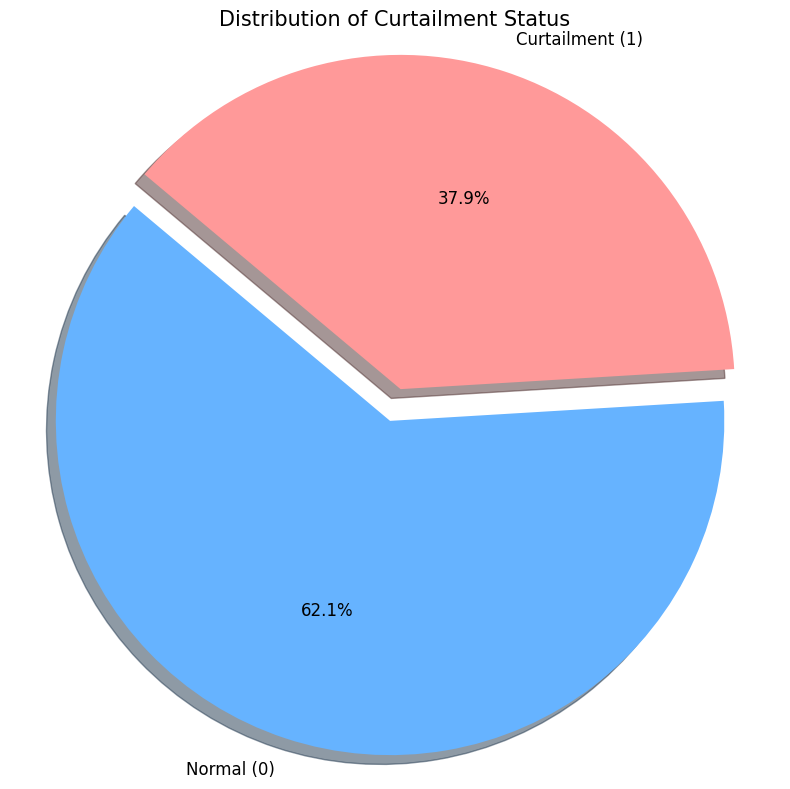

Total Samples per Class:
Curtailment
1.0    5452
0.0    3332
Name: count, dtype: int64


In [ ]:
curtailment_counts = df_curtailment['Curtailment'].value_counts()

labels = ['Normal (0)', 'Curtailment (1)']
colors = ['#66b3ff', '#ff9999']
explode = (0, 0.1)

plt.figure(figsize=(8, 8))
plt.pie(curtailment_counts,
        labels=labels,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        explode=explode,
        shadow=True,
        textprops={'fontsize': 12})

plt.title('Distribution of Curtailment Status', fontsize=15)
plt.axis('equal')
plt.tight_layout()
plt.show()

print("Total Samples per Class:")
print(curtailment_counts)

In [ ]:
rows_with_nan = df_curtailment[df_curtailment.isnull().any(axis=1)]
rows_with_nan

,Timestamp,wtc_ActPower_mean,wtc_AcWindSp_mean,wtc_PrWindSp_mean,wtc_SeWindSp_mean,wtc_NacelTmp_mean,wtc_AmbieTmp_mean,wtc_GenRpm_mean,wtc_MainSRpm_mean,wtc_ActualWindDirection_mean,...,air_density_2,air_density_3,air_density_4,air_density_5,air_density_6,air_density_7,air_density_8,air_density_9,BOA_Volume_hour,Curtailment
8784,2024-09-01 00:00:00+00:00,21308.604622,8.780446,8.780457,9.250933,22.785328,9.152891,1307.389579,14.371488,170.931724,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Saved to: heatmap_wtc_internal.png


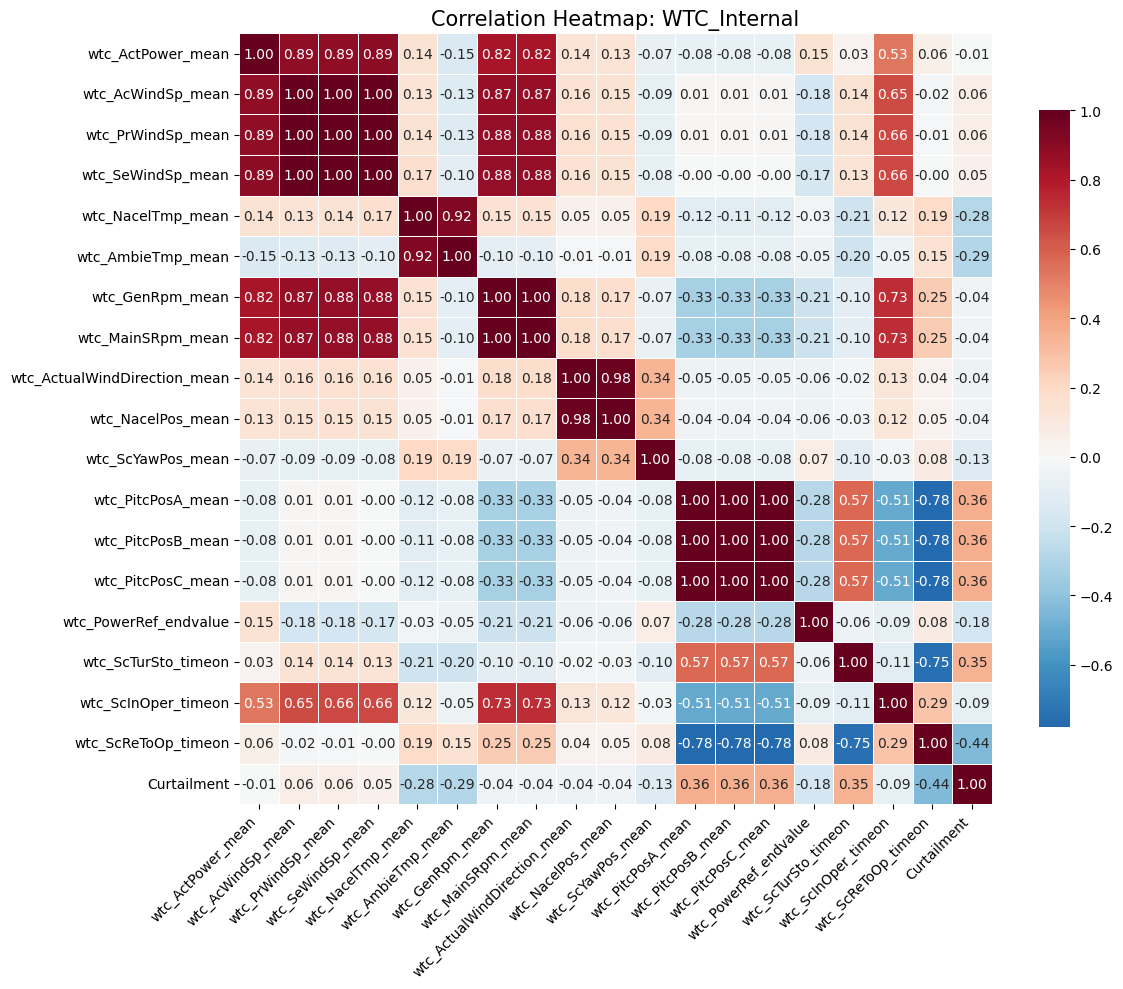

Saved to: heatmap_temperature_points.png


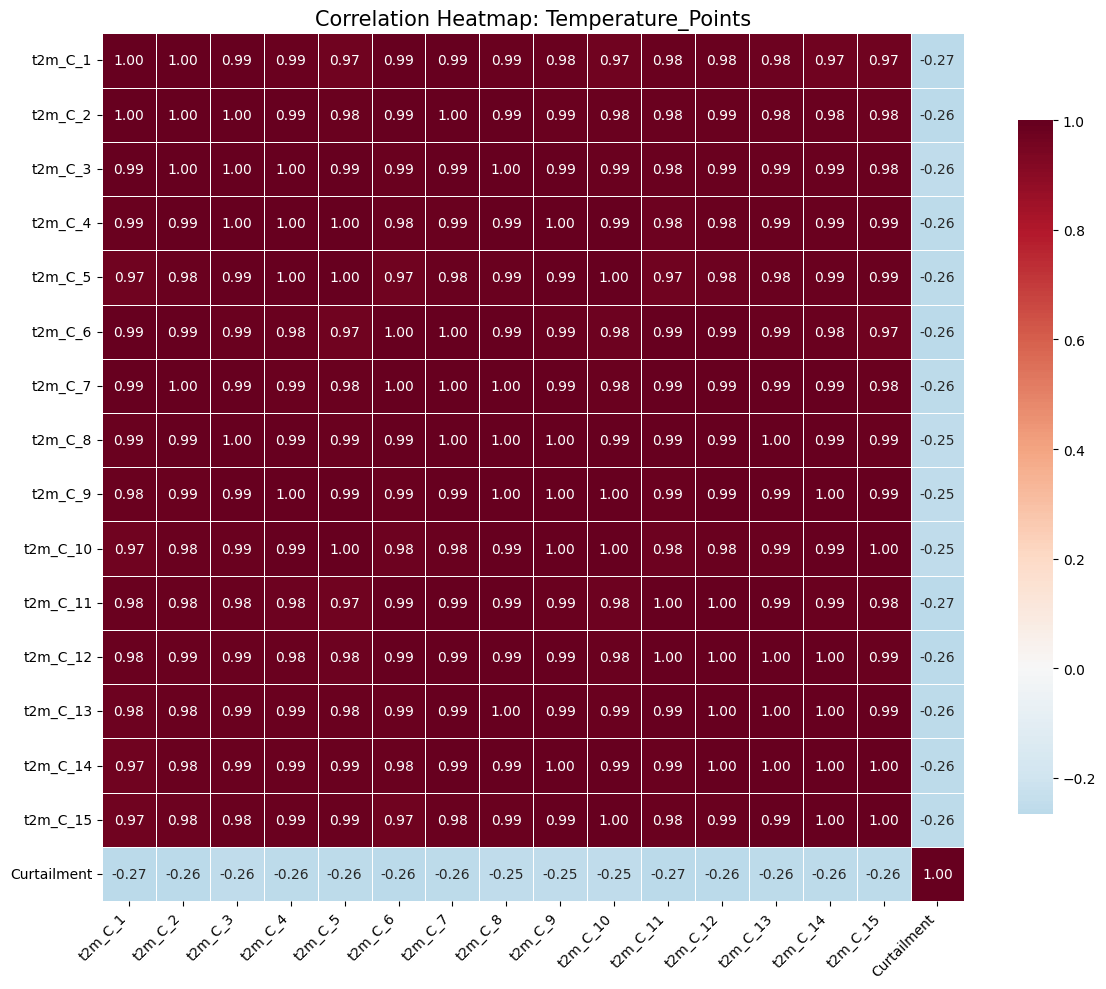

Saved to: heatmap_pressure_points.png


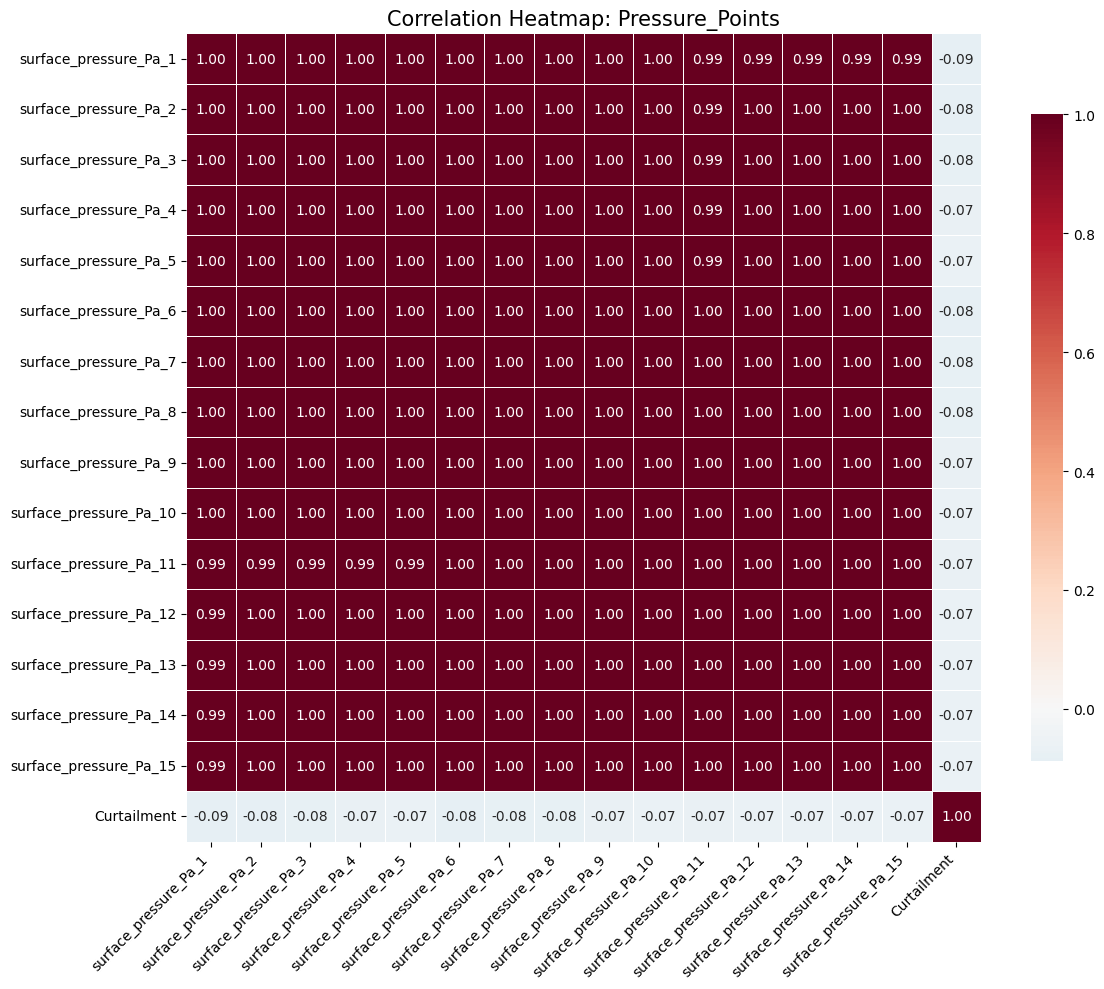

Saved to: heatmap_wind_gust_points.png


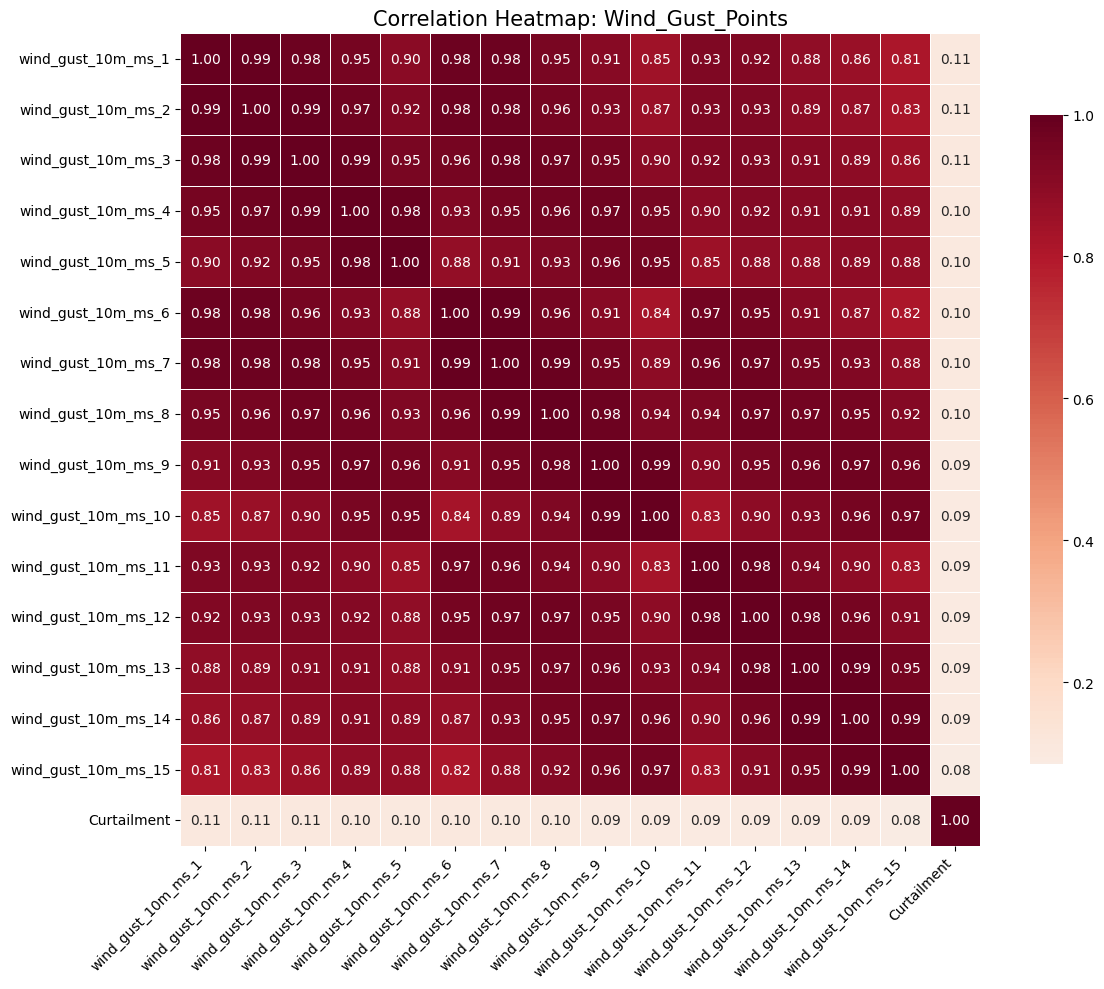

Saved to: heatmap_air_density_points.png


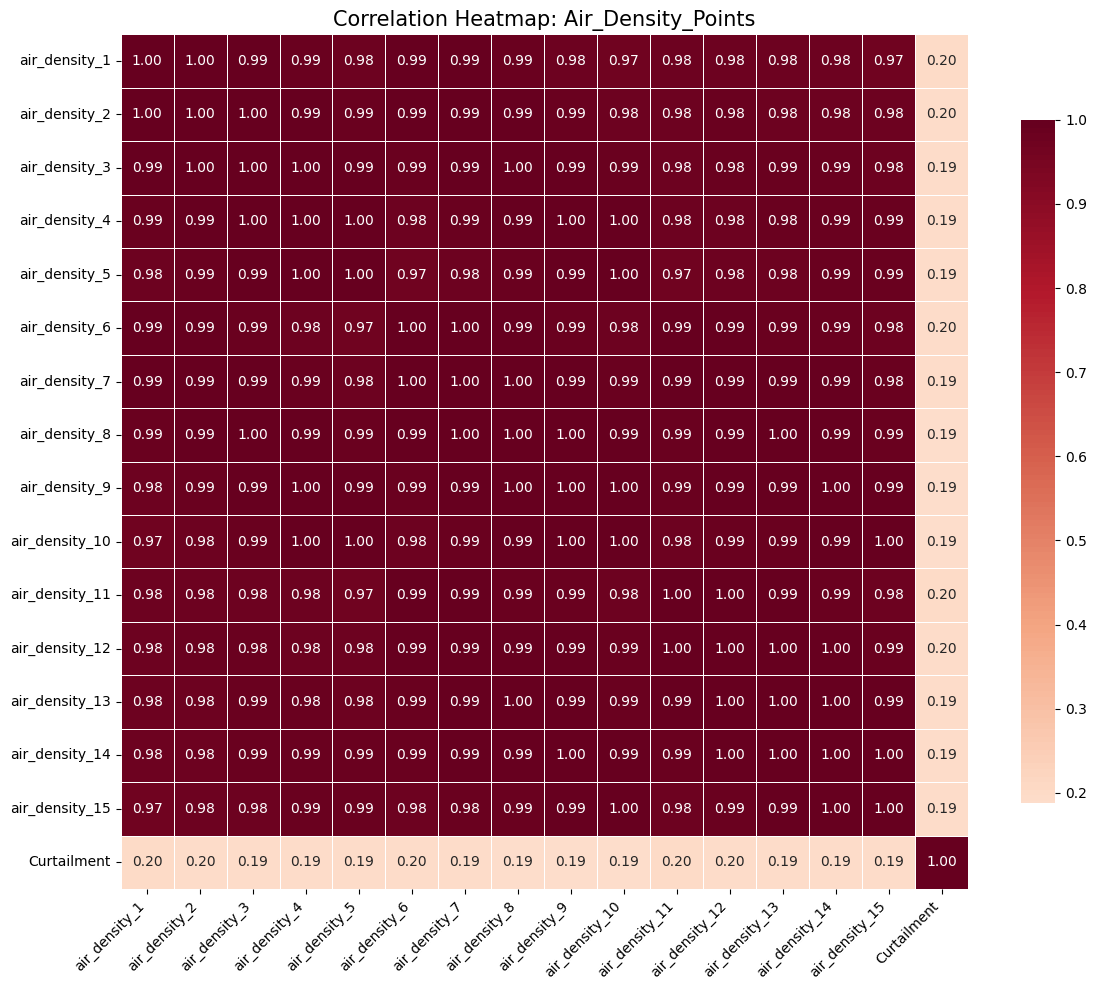

In [ ]:
groups = {
    "WTC_Internal": [col for col in df_curtailment.columns if col.startswith('wtc_')] + ['Curtailment'],
    "Temperature_Points": [f't2m_C_{i}' for i in range(1, 16)] + ['Curtailment'],
    "Pressure_Points": [f'surface_pressure_Pa_{i}' for i in range(1, 16)] + ['Curtailment'],
    "Wind_Gust_Points": [f'wind_gust_10m_ms_{i}' for i in range(1, 16)] + ['Curtailment'],
    "Air_Density_Points": [f'air_density_{i}' for i in range(1, 16)] + ['Curtailment']
}

for group_name, cols in groups.items():
    valid_cols = [c for c in cols if c in df_curtailment.columns]

    if len(valid_cols) > 1:
        plt.figure(figsize=(12, 10))
        corr_matrix = df_curtailment[valid_cols].corr()

        show_annot = True if len(valid_cols) < 20 else False

        sns.heatmap(corr_matrix, annot=show_annot, cmap='RdBu_r', center=0,
                    fmt=".2f", linewidths=0.5, cbar_kws={"shrink": .8})

        plt.title(f'Correlation Heatmap: {group_name}', fontsize=15)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()

        file_name = f'heatmap_{group_name.lower()}.png'
        plt.savefig(file_name)
        print(f"Saved to: {file_name}")
        plt.show()

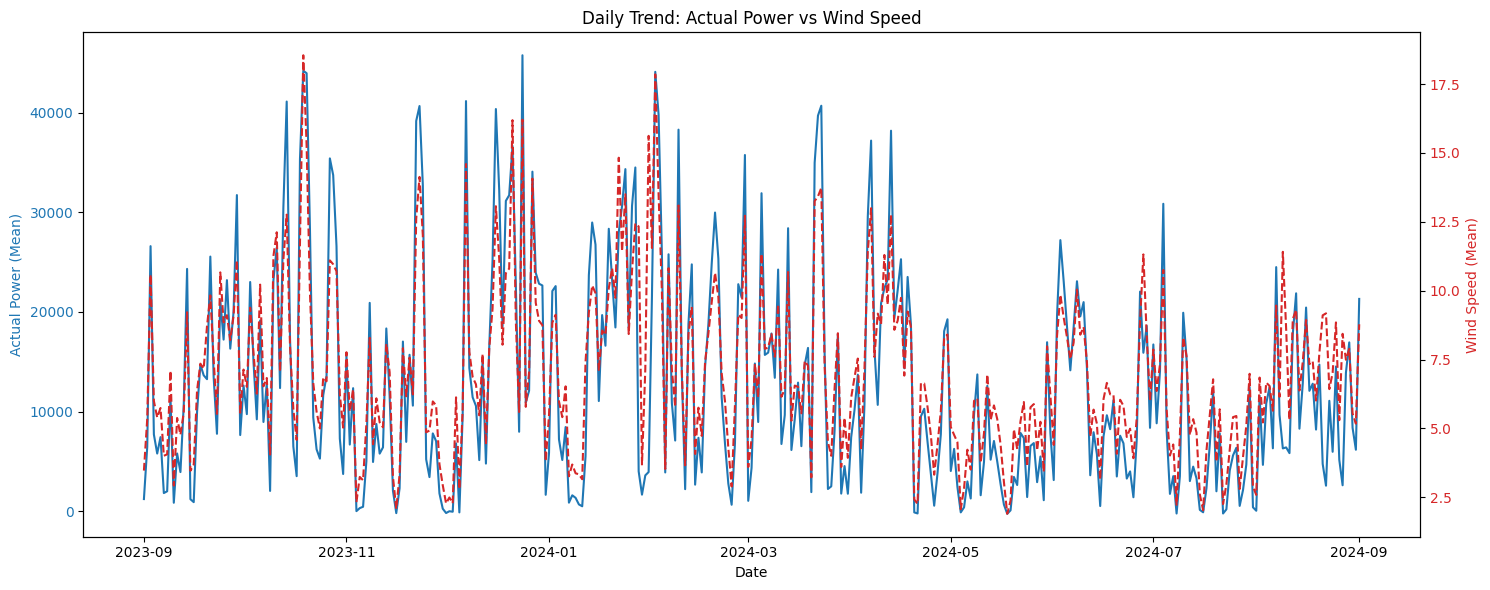

In [60]:
df_curtailment['Timestamp'] = pd.to_datetime(df_curtailment['Timestamp'])
df_curtailment = df_curtailment.sort_values('Timestamp')
df_curtailment_ts = df_curtailment.set_index('Timestamp')

# # Plot (Hourly)
# plt.figure(figsize=(25, 7))
# df_curtailment_ts['Curtailment'].plot(color='orange', alpha=0.6)
# plt.title('Curtailment (Hourly) for 1 year', fontsize=14)
# plt.ylabel('Status (0 or 1)')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()

# 3. Plot (Daily Resampling)
df_numeric = df_curtailment_ts.select_dtypes(include=['number'])
df_daily = df_numeric.resample('D').mean()
fig, ax1 = plt.subplots(figsize=(15, 6))
# Plot ActPower ( Y left)
ax1.set_xlabel('Date')
ax1.set_ylabel('Actual Power (Mean)', color='tab:blue')
ax1.plot(df_daily.index, df_daily['wtc_ActPower_mean'], color='tab:blue', label='Power')
ax1.tick_params(axis='y', labelcolor='tab:blue')
# Plot Wind Speed ( Y right)
ax2 = ax1.twinx()
ax2.set_ylabel('Wind Speed (Mean)', color='tab:red')
ax2.plot(df_daily.index, df_daily['wtc_AcWindSp_mean'], color='tab:red', linestyle='--', label='Wind Speed')
ax2.tick_params(axis='y', labelcolor='tab:red')
plt.title('Daily Trend: Actual Power vs Wind Speed')
fig.tight_layout()
plt.show()

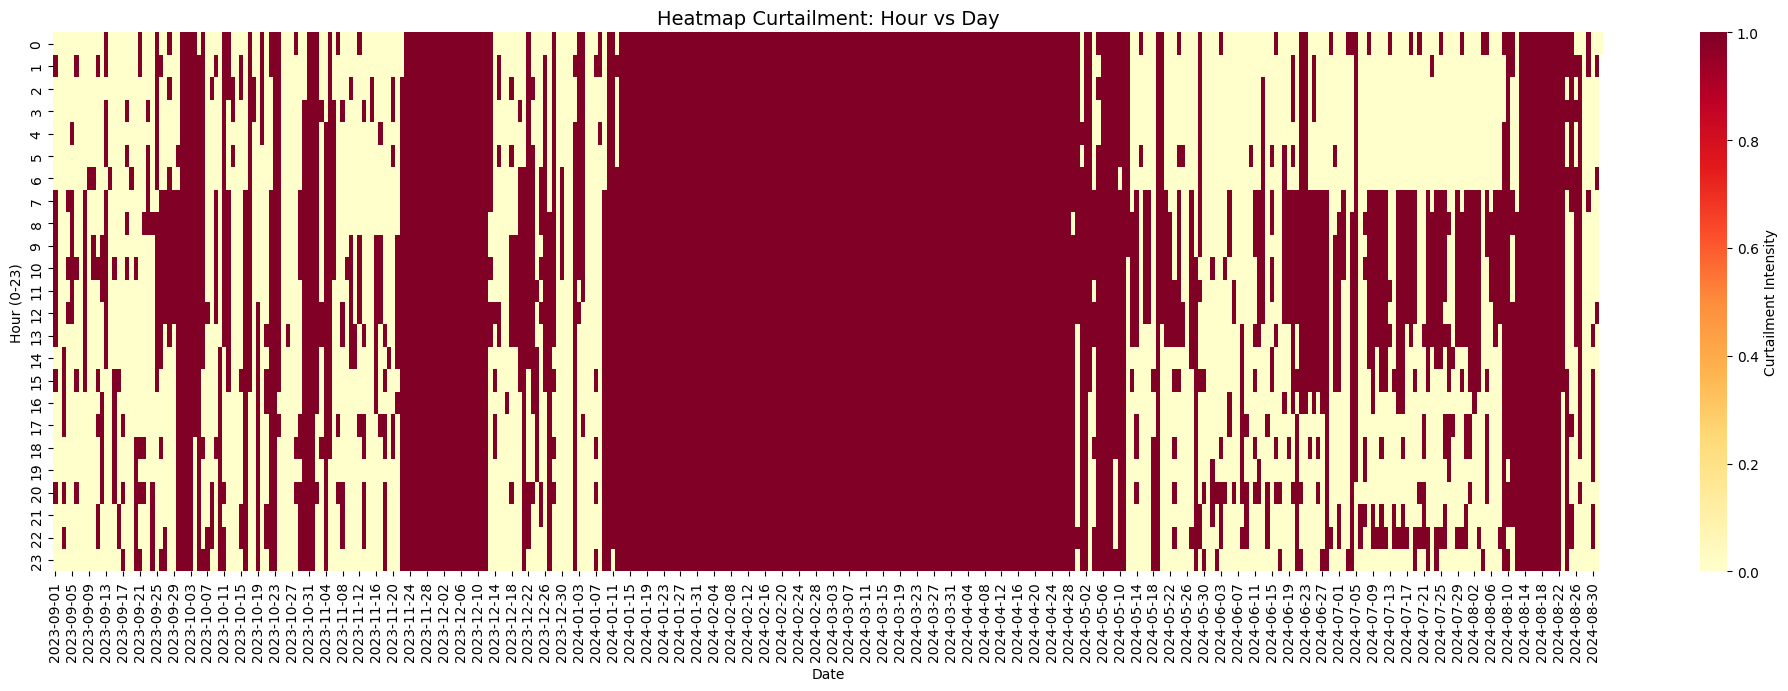

In [61]:
# Heatmap (hourly vs dates)
df_curtailment['hour'] = df_curtailment['Timestamp'].dt.hour
df_curtailment['date'] = df_curtailment['Timestamp'].dt.date
pivot_df_curtailment = df_curtailment.pivot_table(index='hour', columns='date', values='Curtailment', aggfunc='mean')
plt.figure(figsize=(25, 7))
sns.heatmap(pivot_df_curtailment, cmap='YlOrRd', cbar_kws={'label': 'Curtailment Intensity'})
plt.title('Heatmap Curtailment: Hour vs Day', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Hour (0-23)')
plt.show()

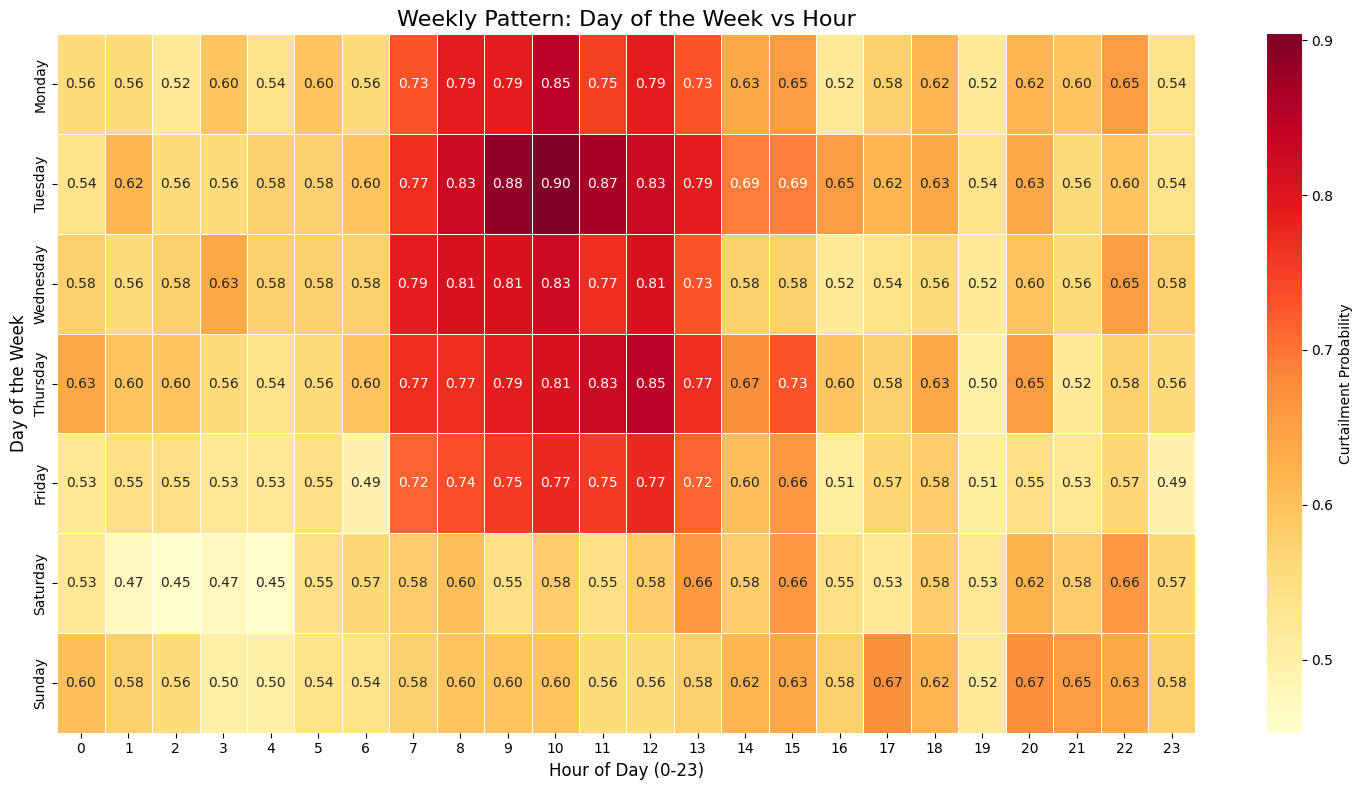

In [62]:
# Heatmap (hourly vs days)
df_curtailment['Timestamp'] = pd.to_datetime(df_curtailment['Timestamp'])
df_curtailment['hour'] = df_curtailment['Timestamp'].dt.hour
df_curtailment['day_name'] = df_curtailment['Timestamp'].dt.day_name()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_weekly = df_curtailment.pivot_table(
    index='day_name',
    columns='hour',
    values='Curtailment',
    aggfunc='mean'
).reindex(days_order)
plt.figure(figsize=(15, 8))
sns.heatmap(
    pivot_weekly,
    cmap='YlOrRd',
    annot=True,     # Menampilkan angka probabilitas (0.0 - 1.0)
    fmt=".2f",      # Format 2 angka di belakang koma
    linewidths=0.5,
    cbar_kws={'label': 'Curtailment Probability'}
)
plt.title('Weekly Pattern: Day of the Week vs Hour', fontsize=16)
plt.xlabel('Hour of Day (0-23)', fontsize=12)
plt.ylabel('Day of the Week', fontsize=12)
plt.tight_layout()
plt.show()

/tmp/ipython-input-2952886969.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_curtailment['Month'] = df_curtailment['Timestamp'].dt.to_period('M')


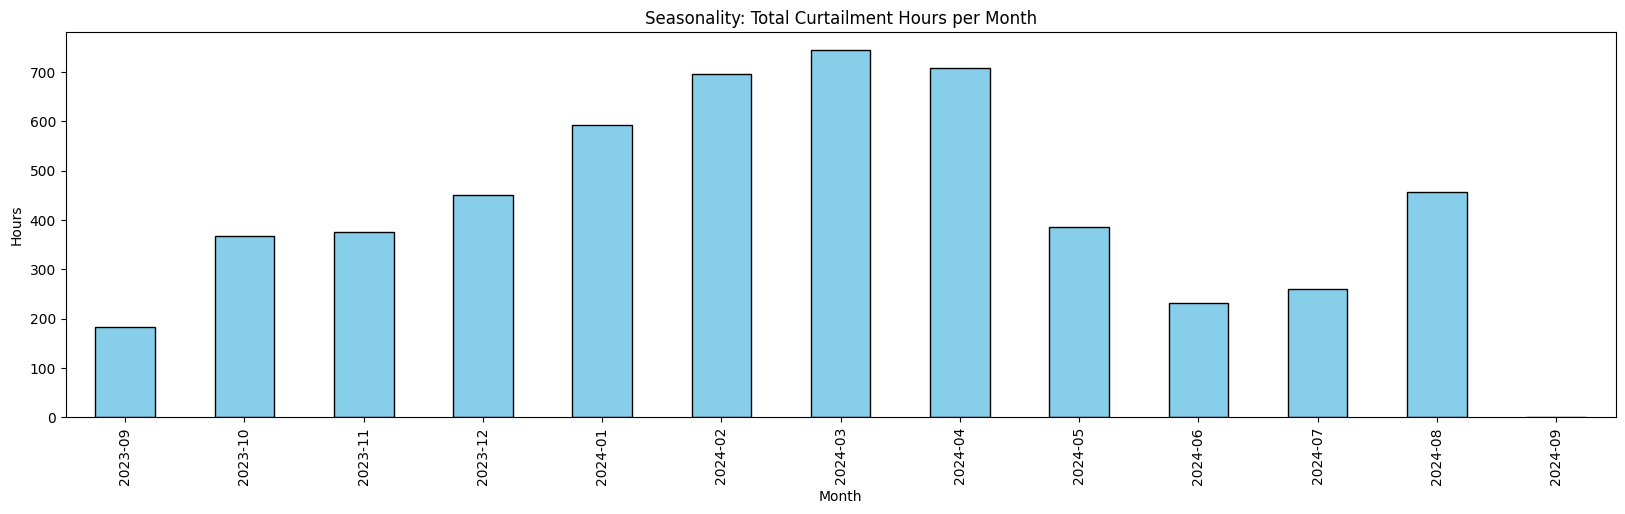

In [63]:
# 1. Monthly Seasonality Plot
df_curtailment['Month'] = df_curtailment['Timestamp'].dt.to_period('M')
monthly_sum = df_curtailment.groupby('Month')['Curtailment'].sum()
plt.figure(figsize=(20, 5))
monthly_sum.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Seasonality: Total Curtailment Hours per Month')
plt.ylabel('Hours')
plt.show()

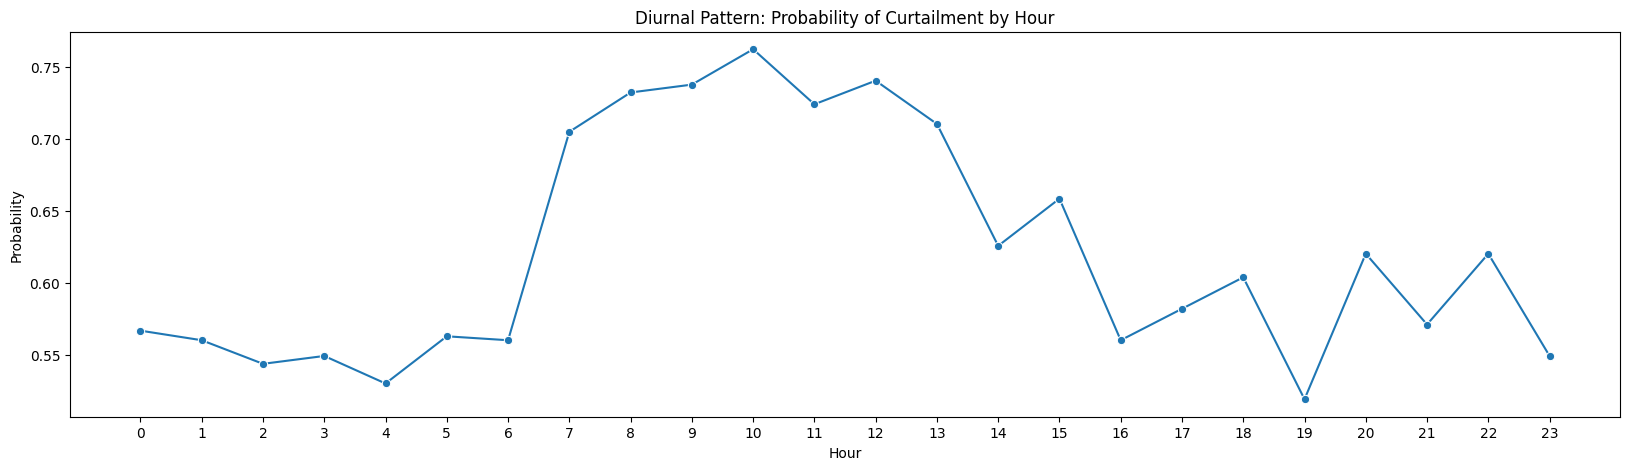

In [64]:
# 2. Hourly Diurnal Profile
df_curtailment['Hour'] = df_curtailment['Timestamp'].dt.hour
hourly_avg = df_curtailment.groupby('Hour')['Curtailment'].mean()
plt.figure(figsize=(20, 5))
sns.lineplot(x=hourly_avg.index, y=hourly_avg.values, marker='o')
plt.title('Diurnal Pattern: Probability of Curtailment by Hour')
plt.xticks(range(0,24))
plt.ylabel('Probability')
plt.show()

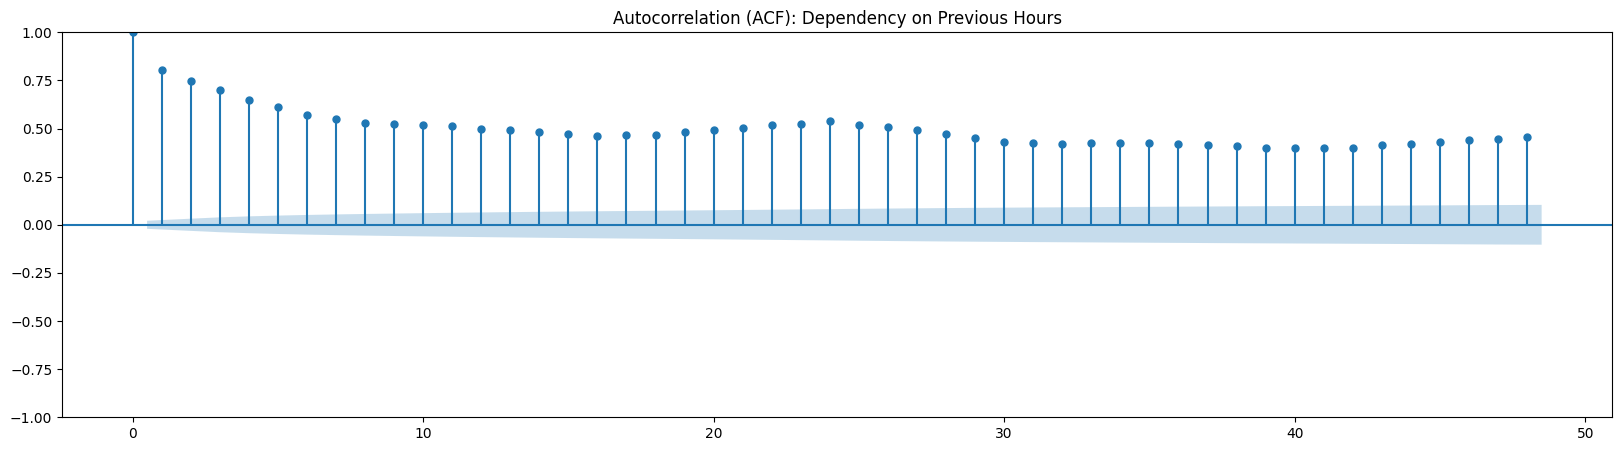

In [65]:
from statsmodels.graphics.tsaplots import plot_acf

# 3. Autocorrelation (ACF)
# Check how many lags are significant
plt.figure(figsize=(20, 5))
plot_acf(df_curtailment['Curtailment'].dropna(), lags=48, ax=plt.gca())
plt.title('Autocorrelation (ACF): Dependency on Previous Hours')
plt.show()

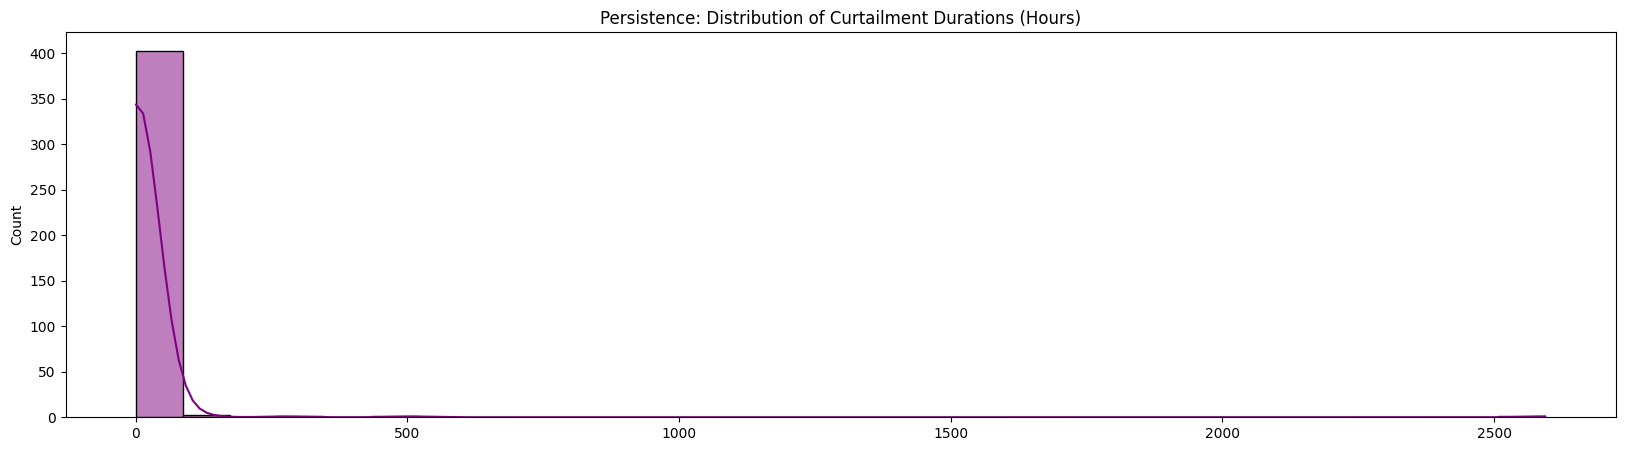

In [66]:
# 4. Event Duration Distribution
# Calculate how many consecutive hours each '1' block lasts
df_curtailment['is_start'] = (df_curtailment['Curtailment'] == 1) & (df_curtailment['Curtailment'].shift(1) == 0)
df_curtailment['event_id'] = df_curtailment['is_start'].cumsum()
durations = df_curtailment[df_curtailment['Curtailment'] == 1].groupby('event_id').size()
plt.figure(figsize=(20, 5))
sns.histplot(durations, bins=30, kde=True, color='purple')
plt.title('Persistence: Distribution of Curtailment Durations (Hours)')
plt.show()

In [67]:
df_curtailment['Timestamp'] = pd.to_datetime(df_curtailment['Timestamp'])
df_curtailment['Month_Check'] = df_curtailment['Timestamp'].dt.month
sanity_check = df_curtailment.groupby('Month_Check')['Curtailment'].value_counts().unstack().fillna(0)
sanity_check.columns = ['Total_Hours_Normal', 'Total_Hours_Curtailment']
sanity_check['Curtailment_Rate (%)'] = (sanity_check['Total_Hours_Curtailment'] /
                                        (sanity_check['Total_Hours_Normal'] + sanity_check['Total_Hours_Curtailment']) * 100)
print("--- Sanity Check: Curtailment per Month ---")
print(sanity_check)

months_to_inspect = [11, 12, 1, 2, 3]
print(f"\n--- Raw Data Samples (Months: {months_to_inspect}) ---")
sample_rows = df_curtailment[df_curtailment['Month_Check'].isin(months_to_inspect)]
print(sample_rows[['Timestamp', 'wtc_AcWindSp_mean', 'wtc_ActPower_mean', 'Curtailment']].head(10))

--- Sanity Check: Curtailment per Month ---
             Total_Hours_Normal  Total_Hours_Curtailment  Curtailment_Rate (%)
Month_Check                                                                   
1                         151.0                    593.0             79.704301
2                           0.0                    696.0            100.000000
3                           0.0                    744.0            100.000000
4                          11.0                    709.0             98.472222
5                         358.0                    386.0             51.881720
6                         488.0                    232.0             32.222222
7                         485.0                    259.0             34.811828
8                         287.0                    457.0             61.424731
9                         539.0                    182.0             25.242718
10                        376.0                    368.0             49.462366
11      

## 2. Feature Engineering

1) **Time-based Features**: extract Timestamp into
    - Hour (0-23): capture daily output in hour
    - Month: capture seasonal pattern
    - DayOfWeek: weekday vs weekend

2) **Lag Features**: adding value from prev 1 or 2 hours (eg wtc_AcWindSp_mean_lag1). Sometimes, curtailment depends on few hours before.

3) **Rolling Statistics**: moving average or standard deviation from wind speed in the last 3-6 hours to capture temperature volatility

4) **Wind Physics**: if possible, calc Turbulence Intensity (standard ratio of wind deviation to avg wind speed).

In [33]:
df_curtailment['Timestamp'] = pd.to_datetime(df_curtailment['Timestamp'])
df_curtailment = df_curtailment.sort_values('Timestamp').reset_index(drop=True)

# Fill missing values using the value from the next hour (Backward Fill)
df_curtailment = df_curtailment.bfill()

# If there is still a NaN at the very end of the dataset, we ffill it as a fallback
df_curtailment = df_curtailment.ffill()

In [34]:
#1: Time-based Features
df_curtailment['hour'] = df_curtailment['Timestamp'].dt.hour
df_curtailment['month'] = df_curtailment['Timestamp'].dt.month
df_curtailment['day_of_week'] = df_curtailment['Timestamp'].dt.dayofweek
df_curtailment['is_weekend'] = df_curtailment['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

In [35]:
#2: Lag Features (1 and 2 hour lags)
lag_features = ['wtc_AcWindSp_mean', 'wtc_ActPower_mean', 'wtc_PitcPosA_mean']
for col in lag_features:
    df_curtailment[f'{col}_lag1'] = df_curtailment[col].shift(1)
    df_curtailment[f'{col}_lag2'] = df_curtailment[col].shift(2)
df_curtailment = df_curtailment.fillna(method='bfill')

/tmp/ipython-input-946506617.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_curtailment = df_curtailment.fillna(method='bfill')


In [36]:
#3: Rolling Statistics (3 and 6 hour windows)
window_sizes = [3, 6]
for window in window_sizes:
    # Rolling Mean for Wind Speed
    df_curtailment[f'wind_speed_rolling_mean_{window}h'] = df_curtailment['wtc_AcWindSp_mean'].rolling(window=window).mean()
    # Rolling Standard Deviation for Wind Speed (captures volatility)
    df_curtailment[f'wind_speed_rolling_std_{window}h'] = df_curtailment['wtc_AcWindSp_mean'].rolling(window=window).std()
df_curtailment = df_curtailment.fillna(method='bfill')

/tmp/ipython-input-44726651.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_curtailment = df_curtailment.fillna(method='bfill')


In [37]:
#4: Wind Physics (Turbulence Intensity)
# Turbulence Intensity = Rolling Std / Rolling Mean
# Using the 3-hour window to capture immediate turbulence
df_curtailment['turbulence_intensity_3h'] = df_curtailment['wind_speed_rolling_std_3h'] / (df_curtailment['wind_speed_rolling_mean_3h'] + 1e-6)
df_curtailment['turbulence_intensity_3h'] = df_curtailment['turbulence_intensity_3h'].clip(0, 1)

In [38]:
#5: Meteorological Feature Aggregation due high multicollinearity
meteo_groups = {
    'temp_mean': [f't2m_C_{i}' for i in range(1, 16)],
    'pressure_mean': [f'surface_pressure_Pa_{i}' for i in range(1, 16)],
    'gust_mean': [f'wind_gust_10m_ms_{i}' for i in range(1, 16)],
    'density_mean': [f'air_density_{i}' for i in range(1, 16)]
}
for new_col, original_cols in meteo_groups.items():
    df_curtailment[new_col] = df_curtailment[original_cols].mean(axis=1)
    df_curtailment.drop(columns=original_cols, inplace=True)

In [39]:
# Change Hour and Month into Cyclical pattern
df_curtailment['hour_sin'] = np.sin(2 * np.pi * df_curtailment['hour']/24)
df_curtailment['hour_cos'] = np.cos(2 * np.pi * df_curtailment['hour']/24)
df_curtailment['month_sin'] = np.sin(2 * np.pi * df_curtailment['month']/12)
df_curtailment['month_cos'] = np.cos(2 * np.pi * df_curtailment['month']/12)

# Difference of request power vs actual power
df_curtailment['power_gap'] = df_curtailment['wtc_PowerRef_endvalue'] - df_curtailment['wtc_ActPower_mean']

# efficiency ratio
df_curtailment['power_per_wind'] = df_curtailment['wtc_ActPower_mean'] / (df_curtailment['wtc_AcWindSp_mean'] + 1e-6)

## 3. Data Splitting
Train 10 months, Test 2 months

In [40]:
rows_with_nan = df_curtailment[df_curtailment.isnull().any(axis=1)]
rows_with_nan

,Timestamp,wtc_ActPower_mean,wtc_AcWindSp_mean,wtc_PrWindSp_mean,wtc_SeWindSp_mean,wtc_NacelTmp_mean,wtc_AmbieTmp_mean,wtc_GenRpm_mean,wtc_MainSRpm_mean,wtc_ActualWindDirection_mean,...,temp_mean,pressure_mean,gust_mean,density_mean,hour_sin,hour_cos,month_sin,month_cos,power_gap,power_per_wind


In [41]:
df_curtailment.columns

Index(['Timestamp', 'wtc_ActPower_mean', 'wtc_AcWindSp_mean',
       'wtc_PrWindSp_mean', 'wtc_SeWindSp_mean', 'wtc_NacelTmp_mean',
       'wtc_AmbieTmp_mean', 'wtc_GenRpm_mean', 'wtc_MainSRpm_mean',
       'wtc_ActualWindDirection_mean', 'wtc_NacelPos_mean',
       'wtc_ScYawPos_mean', 'wtc_PitcPosA_mean', 'wtc_PitcPosB_mean',
       'wtc_PitcPosC_mean', 'wtc_PowerRef_endvalue', 'wtc_ScTurSto_timeon',
       'wtc_ScInOper_timeon', 'wtc_ScReToOp_timeon', 'BOA_Volume_hour',
       'Curtailment', 'hour', 'month', 'day_of_week', 'is_weekend',
       'wtc_AcWindSp_mean_lag1', 'wtc_AcWindSp_mean_lag2',
       'wtc_ActPower_mean_lag1', 'wtc_ActPower_mean_lag2',
       'wtc_PitcPosA_mean_lag1', 'wtc_PitcPosA_mean_lag2',
       'wind_speed_rolling_mean_3h', 'wind_speed_rolling_std_3h',
       'wind_speed_rolling_mean_6h', 'wind_speed_rolling_std_6h',
       'turbulence_intensity_3h', 'temp_mean', 'pressure_mean', 'gust_mean',
       'density_mean', 'hour_sin', 'hour_cos', 'month_sin', 'month_c

In [42]:
groups = {
    "WTC_Internal": [col for col in df_curtailment.columns if col.startswith('wtc_')] + ['Curtailment'],
    "Temperature_Points": [f't2m_C_{i}' for i in range(1, 16)] + ['Curtailment'],
    "Pressure_Points": [f'surface_pressure_Pa_{i}' for i in range(1, 16)] + ['Curtailment'],
    "Wind_Gust_Points": [f'wind_gust_10m_ms_{i}' for i in range(1, 16)] + ['Curtailment'],
    "Air_Density_Points": [f'air_density_{i}' for i in range(1, 16)] + ['Curtailment']
}

for group_name, cols in groups.items():
    print(group_name, '\n', cols)

print("Cols with Mean \n",[col for col in df_curtailment.columns if col.endswith('_mean')])

WTC_Internal 
 ['wtc_ActPower_mean', 'wtc_AcWindSp_mean', 'wtc_PrWindSp_mean', 'wtc_SeWindSp_mean', 'wtc_NacelTmp_mean', 'wtc_AmbieTmp_mean', 'wtc_GenRpm_mean', 'wtc_MainSRpm_mean', 'wtc_ActualWindDirection_mean', 'wtc_NacelPos_mean', 'wtc_ScYawPos_mean', 'wtc_PitcPosA_mean', 'wtc_PitcPosB_mean', 'wtc_PitcPosC_mean', 'wtc_PowerRef_endvalue', 'wtc_ScTurSto_timeon', 'wtc_ScInOper_timeon', 'wtc_ScReToOp_timeon', 'wtc_AcWindSp_mean_lag1', 'wtc_AcWindSp_mean_lag2', 'wtc_ActPower_mean_lag1', 'wtc_ActPower_mean_lag2', 'wtc_PitcPosA_mean_lag1', 'wtc_PitcPosA_mean_lag2', 'Curtailment']
Temperature_Points 
 ['t2m_C_1', 't2m_C_2', 't2m_C_3', 't2m_C_4', 't2m_C_5', 't2m_C_6', 't2m_C_7', 't2m_C_8', 't2m_C_9', 't2m_C_10', 't2m_C_11', 't2m_C_12', 't2m_C_13', 't2m_C_14', 't2m_C_15', 'Curtailment']
Pressure_Points 
 ['surface_pressure_Pa_1', 'surface_pressure_Pa_2', 'surface_pressure_Pa_3', 'surface_pressure_Pa_4', 'surface_pressure_Pa_5', 'surface_pressure_Pa_6', 'surface_pressure_Pa_7', 'surface_press

In [43]:
target = 'Curtailment'
exclude_features = ['Timestamp', 'BOA_Volume_hour', 'Curtailment']

X = df_curtailment.drop(columns=exclude_features)
y = df_curtailment[target]

In [44]:
cutoff_date = '2024-06-01'

train_mask = df_curtailment['Timestamp'] < cutoff_date
test_mask = df_curtailment['Timestamp'] >= cutoff_date

X_train = X[train_mask]
y_train = y[train_mask]

X_test = X[test_mask]
y_test = y[test_mask]

print(f"Part 3 complete: Split by date '{cutoff_date}'")
print(f"Training Range: {df_curtailment[train_mask]['Timestamp'].min()} to {df_curtailment[train_mask]['Timestamp'].max()}")
print(f"Testing Range:  {df_curtailment[test_mask]['Timestamp'].min()} to {df_curtailment[test_mask]['Timestamp'].max()}")
print(f"Total Train Samples: {len(X_train)} | Total Test Samples: {len(X_test)}")

Part 3 complete: Split by date '2024-06-01'
Training Range: 2023-09-01 00:00:00+00:00 to 2024-05-31 23:00:00+00:00
Testing Range:  2024-06-01 00:00:00+00:00 to 2024-09-01 00:00:00+00:00
Total Train Samples: 6576 | Total Test Samples: 2209


## 4. Model Training
Tree-ensemble:

1) **Baseline Model** <br>
Random Forest or Logistic Regression

2) **Advanced Models** <br>
Neural Networks (MLP)

3) **Hyperparameter Tuning** <br>
Time Series Cross-Validation use time-based feature for best parameter search (e.g. max_depth, learning_rate).

## 5. Model Evaluation
comprehensive

1) **Confusion Matrix** <br>
see on how many curtailment events failed to predict (False Negatives).

2) **Precision & Recall** <br>
important cost of failed prediction (e.g. waste wind energy vs limited wind energy).

3) **F1-Score**

4) **AUC-ROC** <br>
see how good model can define Curtailment (1) and Normal (0).

5) **Feature Importance** <br>
which features are best influenc to model prediction on Curtailment

In [45]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance

In [46]:
df_curtailment.columns

Index(['Timestamp', 'wtc_ActPower_mean', 'wtc_AcWindSp_mean',
       'wtc_PrWindSp_mean', 'wtc_SeWindSp_mean', 'wtc_NacelTmp_mean',
       'wtc_AmbieTmp_mean', 'wtc_GenRpm_mean', 'wtc_MainSRpm_mean',
       'wtc_ActualWindDirection_mean', 'wtc_NacelPos_mean',
       'wtc_ScYawPos_mean', 'wtc_PitcPosA_mean', 'wtc_PitcPosB_mean',
       'wtc_PitcPosC_mean', 'wtc_PowerRef_endvalue', 'wtc_ScTurSto_timeon',
       'wtc_ScInOper_timeon', 'wtc_ScReToOp_timeon', 'BOA_Volume_hour',
       'Curtailment', 'hour', 'month', 'day_of_week', 'is_weekend',
       'wtc_AcWindSp_mean_lag1', 'wtc_AcWindSp_mean_lag2',
       'wtc_ActPower_mean_lag1', 'wtc_ActPower_mean_lag2',
       'wtc_PitcPosA_mean_lag1', 'wtc_PitcPosA_mean_lag2',
       'wind_speed_rolling_mean_3h', 'wind_speed_rolling_std_3h',
       'wind_speed_rolling_mean_6h', 'wind_speed_rolling_std_6h',
       'turbulence_intensity_3h', 'temp_mean', 'pressure_mean', 'gust_mean',
       'density_mean', 'hour_sin', 'hour_cos', 'month_sin', 'month_c

In [47]:
X.columns

Index(['wtc_ActPower_mean', 'wtc_AcWindSp_mean', 'wtc_PrWindSp_mean',
       'wtc_SeWindSp_mean', 'wtc_NacelTmp_mean', 'wtc_AmbieTmp_mean',
       'wtc_GenRpm_mean', 'wtc_MainSRpm_mean', 'wtc_ActualWindDirection_mean',
       'wtc_NacelPos_mean', 'wtc_ScYawPos_mean', 'wtc_PitcPosA_mean',
       'wtc_PitcPosB_mean', 'wtc_PitcPosC_mean', 'wtc_PowerRef_endvalue',
       'wtc_ScTurSto_timeon', 'wtc_ScInOper_timeon', 'wtc_ScReToOp_timeon',
       'hour', 'month', 'day_of_week', 'is_weekend', 'wtc_AcWindSp_mean_lag1',
       'wtc_AcWindSp_mean_lag2', 'wtc_ActPower_mean_lag1',
       'wtc_ActPower_mean_lag2', 'wtc_PitcPosA_mean_lag1',
       'wtc_PitcPosA_mean_lag2', 'wind_speed_rolling_mean_3h',
       'wind_speed_rolling_std_3h', 'wind_speed_rolling_mean_6h',
       'wind_speed_rolling_std_6h', 'turbulence_intensity_3h', 'temp_mean',
       'pressure_mean', 'gust_mean', 'density_mean', 'hour_sin', 'hour_cos',
       'month_sin', 'month_cos', 'power_gap', 'power_per_wind'],
      dtype='obje

In [48]:
print(y)

0       0.0
1       1.0
2       0.0
3       0.0
4       0.0
       ... 
8780    0.0
8781    0.0
8782    0.0
8783    0.0
8784    0.0
Name: Curtailment, Length: 8785, dtype: float64


### a. Logistic Regression

In [54]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 'liblinear' solver for small/medium datasets or 'saga' for large ones
# 'max_iter' is increased to ensure the model finds the best solution
log_reg = LogisticRegression(max_iter=1000, random_state=42, solver='saga', penalty='l1')
log_reg.fit(X_train_scaled, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=1000, penalty='l1', random_state=42, solver='saga')

In [55]:
y_pred_lr = log_reg.predict(X_test_scaled)
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

print("\n--- Logistic Regression Performance ---")
print(classification_report(y_test, y_pred_lr))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob_lr):.4f}")


--- Logistic Regression Performance ---
              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93      1261
         1.0       0.97      0.82      0.89       948

    accuracy                           0.91      2209
   macro avg       0.92      0.90      0.91      2209
weighted avg       0.92      0.91      0.91      2209

ROC-AUC Score: 0.9547


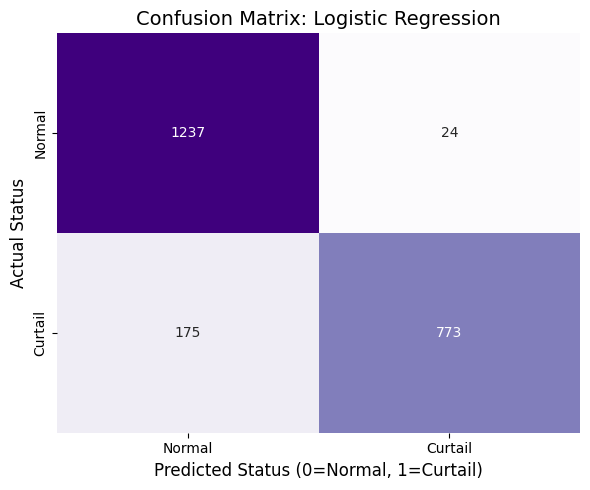

True Negatives: 1237
False Positives: 24
False Negatives: 175
True Positives: 773


In [56]:
# Plot Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Purples', cbar=False)

plt.title('Confusion Matrix: Logistic Regression', fontsize=14)
plt.xlabel('Predicted Status (0=Normal, 1=Curtail)', fontsize=12)
plt.ylabel('Actual Status', fontsize=12)
plt.xticks([0.5, 1.5], ['Normal', 'Curtail'])
plt.yticks([0.5, 1.5], ['Normal', 'Curtail'])
plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm_lr.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

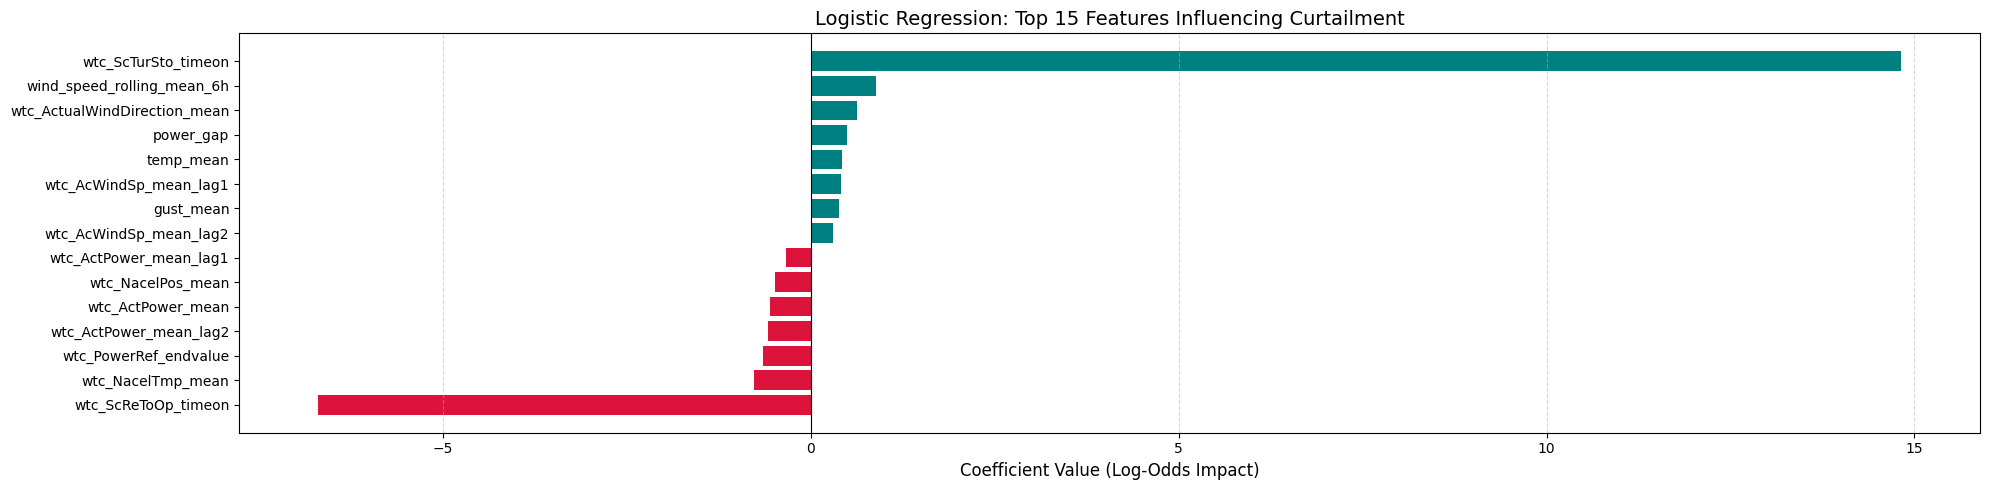

--- Coefficient Analysis Summary ---
Top Positive Drivers (Increase Curtailment probability):
                         Feature  Coefficient
15           wtc_ScTurSto_timeon    14.815437
30    wind_speed_rolling_mean_6h     0.878656
8   wtc_ActualWindDirection_mean     0.625178
41                     power_gap     0.497146
33                     temp_mean     0.422312

Top Negative Drivers (Decrease Curtailment probability):
                   Feature  Coefficient
17     wtc_ScReToOp_timeon    -6.695937
4        wtc_NacelTmp_mean    -0.769500
14   wtc_PowerRef_endvalue    -0.645098
25  wtc_ActPower_mean_lag2    -0.575898
0        wtc_ActPower_mean    -0.560320


In [57]:
# COEFFICIENT ANALYSIS (The "Feature Importance" of Logistic Regression)
# In LogReg, we look at coefficients to see the direction of influence

coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_reg.coef_[0]
})

coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

plt.figure(figsize=(20, 5))
top_coefs = coef_df.head(15).sort_values(by='Coefficient')    # top 15 most important features

colors = ['crimson' if x < 0 else 'teal' for x in top_coefs['Coefficient']]
plt.barh(top_coefs['Feature'], top_coefs['Coefficient'], color=colors)

plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.title('Logistic Regression: Top 15 Features Influencing Curtailment', fontsize=14)
plt.xlabel('Coefficient Value (Log-Odds Impact)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 5. SUMMARY INTERPRETATION
print("--- Coefficient Analysis Summary ---")
print("Top Positive Drivers (Increase Curtailment probability):")
print(coef_df[coef_df['Coefficient'] > 0].head(5)[['Feature', 'Coefficient']])
print("\nTop Negative Drivers (Decrease Curtailment probability):")
print(coef_df[coef_df['Coefficient'] < 0].head(5)[['Feature', 'Coefficient']])

In [58]:
lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'] # Required for l1 penalty
}

tscv = TimeSeriesSplit(n_splits=5)
lr_grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000, random_state=42),
    param_grid=lr_param_grid,
    cv=tscv,
    scoring='roc_auc',
    n_jobs=-1
)

lr_grid.fit(X_train_scaled, y_train)

print(f"Best LogReg Parameters: {lr_grid.best_params_}")
print(f"Best LogReg ROC-AUC Score: {lr_grid.best_score_:.4f}")

best_lr = lr_grid.best_estimator_

Best LogReg Parameters: {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
Best LogReg ROC-AUC Score: nan


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


### b. Random Forest

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=100, # n_estimators: Number of trees in the forest
    max_depth=12,     # max_depth: Limits tree growth to prevent overfitting
    random_state=42,  # n_jobs=-1: Uses all available CPU cores for faster training
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, n_jobs=-1, random_state=42)

In [ ]:
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1] # Probability for the positive class (Curtailment=1)

print("\n--- Model Performance Report ---")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")


--- Model Performance Report ---
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      1261
         1.0       0.95      0.92      0.93       948

    accuracy                           0.94      2209
   macro avg       0.94      0.94      0.94      2209
weighted avg       0.94      0.94      0.94      2209

ROC-AUC Score: 0.9749


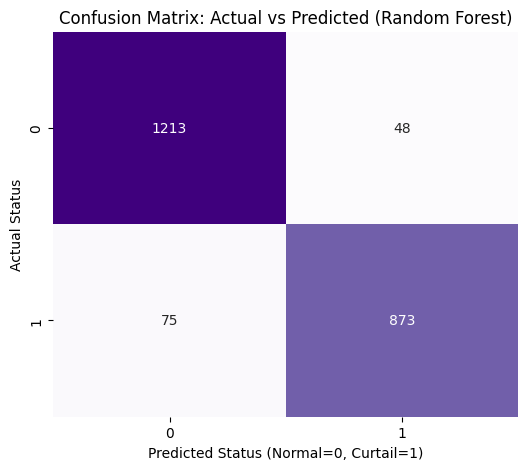

In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.title('Confusion Matrix: Actual vs Predicted (Random Forest)')
plt.xlabel('Predicted Status (Normal=0, Curtail=1)')
plt.ylabel('Actual Status')
plt.show()

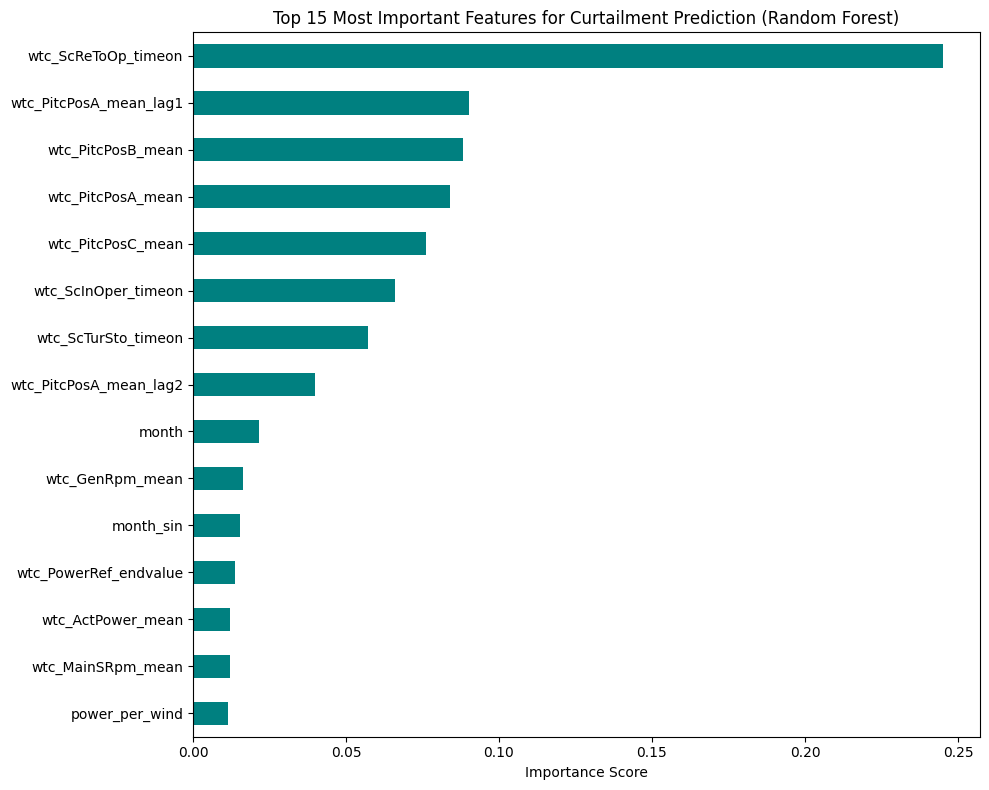

In [ ]:
# Plot Feature Importance
# This tells you which features (e.g., Wind Speed vs. Hour) are the most predictive
plt.figure(figsize=(10, 8))
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.nlargest(15).sort_values().plot(kind='barh', color='teal')
plt.title('Top 15 Most Important Features for Curtailment Prediction (Random Forest)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_param_grid,
    n_iter=10, # Number of parameter combinations to try
    cv=tscv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

rf_random.fit(X_train, y_train)

print(f"Best RF Parameters: {rf_random.best_params_}")
print(f"Best RF ROC-AUC Score: {rf_random.best_score_:.4f}")

best_rf = rf_random.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best RF Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 15}
Best RF ROC-AUC Score: nan


### c. Neural Network (Multi Layer Perceptron - MLP)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)

mlp.fit(X_train_scaled, y_train)

MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)

In [ ]:
y_pred_mlp = mlp.predict(X_test_scaled)
y_prob_mlp = mlp.predict_proba(X_test_scaled)[:, 1]

print(f"--- MLP Model Report (Test Months: {cutoff_date} onwards) ---")
print(classification_report(y_test, y_pred_mlp))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob_mlp):.4f}")

--- MLP Model Report (Test Months: 2024-06-01 onwards) ---
              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91      1261
         1.0       0.91      0.83      0.87       948

    accuracy                           0.89      2209
   macro avg       0.89      0.88      0.89      2209
weighted avg       0.89      0.89      0.89      2209

ROC-AUC Score: 0.9364


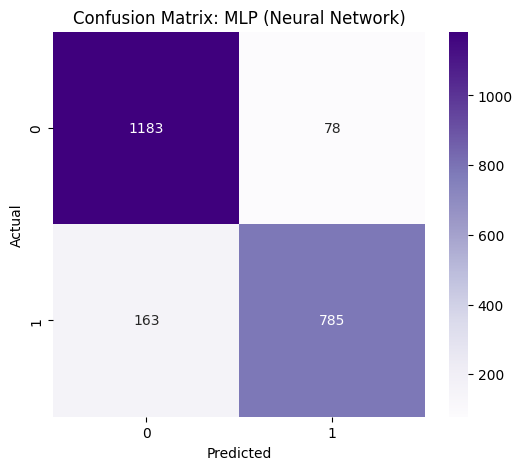

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_mlp), annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix: MLP (Neural Network)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/tmp/ipython-input-1347739798.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_15_non_time, x='Importance', y='Feature', palette='mako')


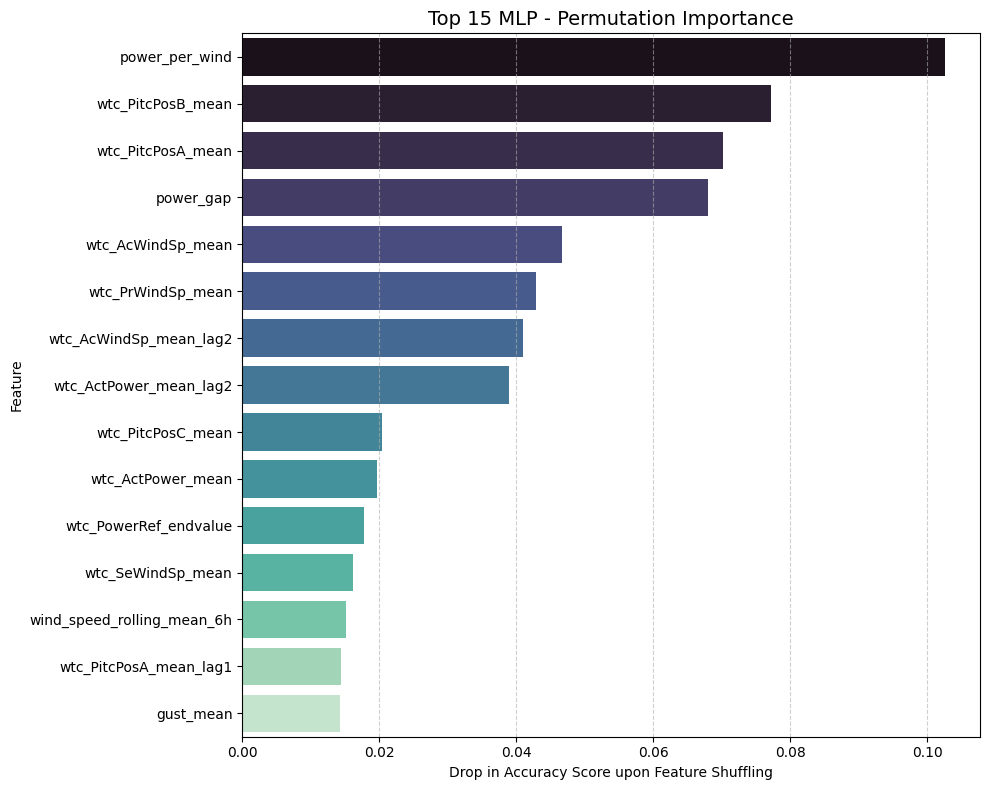

In [ ]:
# Calc Permutation Importance
# n_repeats=5 --> 5 times randomize each feature for stable result
result = permutation_importance(mlp, X_test_scaled, y_test, n_repeats=5, random_state=42, n_jobs=-1)

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
})

time_keywords = ['hour', 'month', 'sin', 'cos', 'day', 'time', 'weekend']
non_time_importance = importance_df[~importance_df['Feature'].str.contains('|'.join(time_keywords), case=False)]

top_15_non_time = non_time_importance.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(data=top_15_non_time, x='Importance', y='Feature', palette='mako')
plt.title('Top 15 MLP - Permutation Importance', fontsize=14)
plt.xlabel('Drop in Accuracy Score upon Feature Shuffling')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
mlp_param_grid = {
    'hidden_layer_sizes': [(64,), (100,), (64, 32), (100, 50)],
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.001, 0.01], # L2 penalty (regularization)
    'learning_rate_init': [0.001, 0.01]
}

mlp_random = RandomizedSearchCV(
    estimator=MLPClassifier(max_iter=500, random_state=42),
    param_distributions=mlp_param_grid,
    n_iter=8,
    cv=tscv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

mlp_random.fit(X_train_scaled, y_train)

print(f"Best MLP Parameters: {mlp_random.best_params_}")
print(f"Best MLP ROC-AUC Score: {mlp_random.best_score_:.4f}")

best_mlp = mlp_random.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


Best MLP Parameters: {'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 50), 'alpha': 0.001, 'activation': 'relu'}
Best MLP ROC-AUC Score: nan


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64, 32),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
)

mlp.fit(X_train_scaled, y_train)

MLPClassifier(hidden_layer_sizes=(256, 128, 64, 32), max_iter=1000,
              random_state=42)

In [ ]:
y_pred_mlp = mlp.predict(X_test_scaled)
y_prob_mlp = mlp.predict_proba(X_test_scaled)[:, 1]

print(f"--- MLP Model Report (Test Months: {cutoff_date} onwards) ---")
print(classification_report(y_test, y_pred_mlp))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob_mlp):.4f}")

--- MLP Model Report (Test Months: 2024-06-01 onwards) ---
              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90      1261
         1.0       0.90      0.83      0.86       948

    accuracy                           0.89      2209
   macro avg       0.89      0.88      0.88      2209
weighted avg       0.89      0.89      0.89      2209

ROC-AUC Score: 0.9309


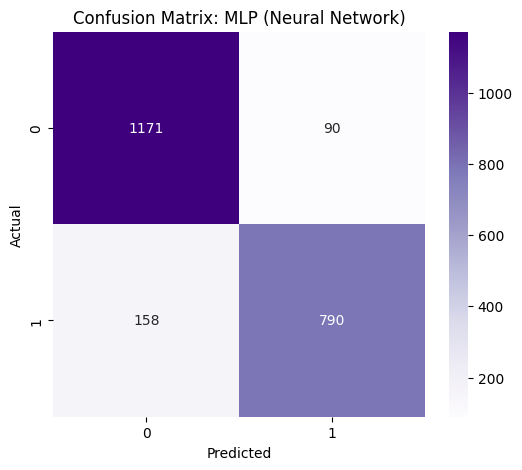

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_mlp), annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix: MLP (Neural Network)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/tmp/ipython-input-1347739798.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_15_non_time, x='Importance', y='Feature', palette='mako')


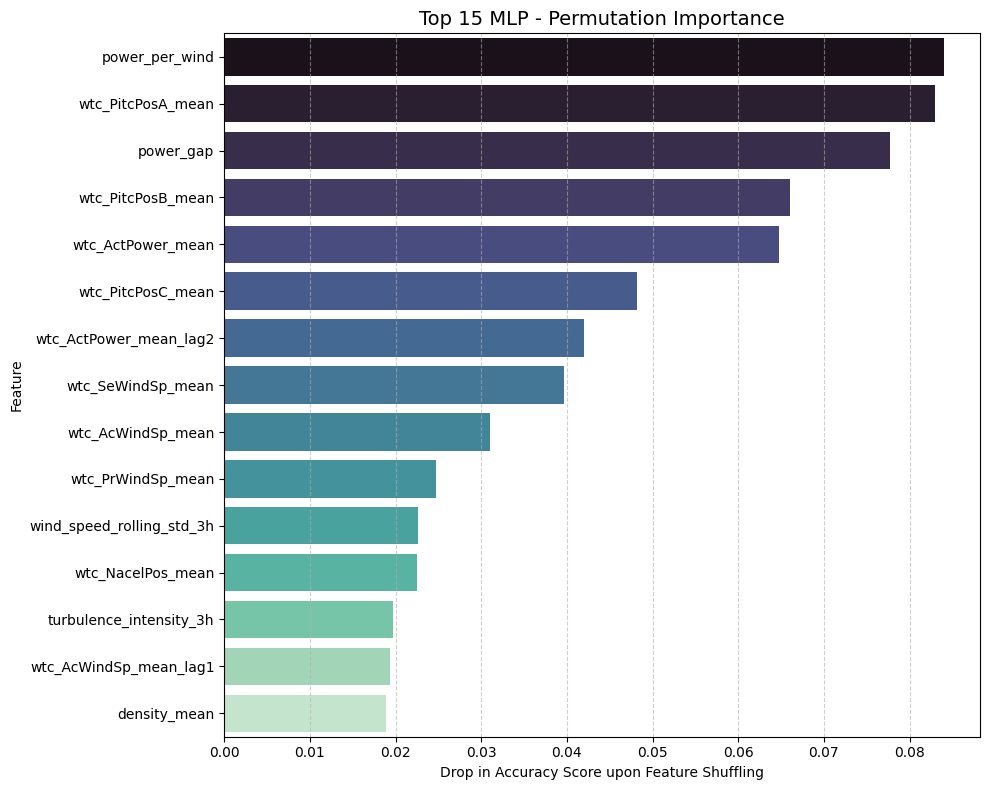

In [ ]:
# Calc Permutation Importance
# n_repeats=5 --> 5 times randomize each feature for stable result
result = permutation_importance(mlp, X_test_scaled, y_test, n_repeats=5, random_state=42, n_jobs=-1)

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
})

time_keywords = ['hour', 'month', 'sin', 'cos', 'day', 'time', 'weekend']
non_time_importance = importance_df[~importance_df['Feature'].str.contains('|'.join(time_keywords), case=False)]

top_15_non_time = non_time_importance.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(data=top_15_non_time, x='Importance', y='Feature', palette='mako')
plt.title('Top 15 MLP - Permutation Importance', fontsize=14)
plt.xlabel('Drop in Accuracy Score upon Feature Shuffling')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Morray Demand Clustering

**Input:** <br>
Hill of Towie_Hourly_Demand+Price_Final.csv

**Process:** <br>
1. Filter in one-year period 01092023 - 31082024
2. Elbow method for finding best K number for clustering
3. K-Means clustering using selected best K

**Output:** <br>
Clusters of Moral Local Demand

In [ ]:
#Load demand data
df_demand = pd.read_csv("/content/drive/MyDrive/EDA/Hill of Towie_Hourly_Demand+Price_Final.csv")

In [ ]:
#Show the top 10 rows of the uploaded data
df_demand.head(10)

,Timestamp,SCOTLAND_DEMAND,Moray_Local_Demand,Market_Price_GBP
0,1/1/2022 0:00,1416.5,30.3131,131.89
1,1/1/2022 1:00,1177.5,25.1985,88.45
2,1/1/2022 2:00,922.5,19.7415,23.91
3,1/1/2022 3:00,868.5,18.5859,7.27
4,1/1/2022 4:00,807.0,17.2698,-6.31
5,1/1/2022 5:00,728.0,15.5792,-18.05
6,1/1/2022 6:00,709.5,15.1833,-17.97
7,1/1/2022 7:00,689.5,14.7553,-31.39
8,1/1/2022 8:00,743.0,15.9002,-21.70
9,1/1/2022 9:00,907.0,19.4098,13.29


In [ ]:
#Converts text column into datetime object
df_demand['Timestamp'] = pd.to_datetime(df_demand['Timestamp'],dayfirst=True)

In [ ]:
#Filter the data for only the analysis period
start_date = '2023-09-01 00:00:00'
end_date = '2024-08-31 23:59:59'

period = (df_demand['Timestamp'] >= start_date) & (df_demand['Timestamp']<= end_date)
df_filtered = df_demand.loc[period].copy()

In [ ]:
#Ensure timestamp data in chronological order
df_filtered = df_filtered.sort_values(by='Timestamp')

In [ ]:
#Show the top 10 rows of the filtered data
df_filtered.head(10)

,Timestamp,SCOTLAND_DEMAND,Moray_Local_Demand,Market_Price_GBP
14591,2023-09-01 00:00:00,1852.0,39.6328,82.86
14592,2023-09-01 01:00:00,1785.0,38.1990,79.92
14593,2023-09-01 02:00:00,1737.0,37.1718,77.37
14594,2023-09-01 03:00:00,1720.5,36.8187,75.69
14595,2023-09-01 04:00:00,1700.0,36.3800,76.85
14596,2023-09-01 05:00:00,1751.0,37.4714,82.46
14597,2023-09-01 06:00:00,1933.5,41.3769,95.33
14598,2023-09-01 07:00:00,2300.0,49.2200,106.22
14599,2023-09-01 08:00:00,2527.0,54.0778,105.21
14600,2023-09-01 09:00:00,2557.0,54.7198,97.53


In [ ]:
#Converts text column into datetime object
df_filtered['Timestamp'] = pd.to_datetime(df_filtered['Timestamp'],dayfirst=True)

In [ ]:
#Save the file to CSV format for future use
df_filtered.to_csv("/content/drive/MyDrive/EDA/Filtered Demand_Final.csv", index=False)

In [ ]:
#Feature engineering - creates a column that isolates specific hour of the day
df_filtered['Hour'] = df_filtered['Timestamp'].dt.hour

In [ ]:
#Standardise the data
X = df_filtered[['Moray_Local_Demand']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

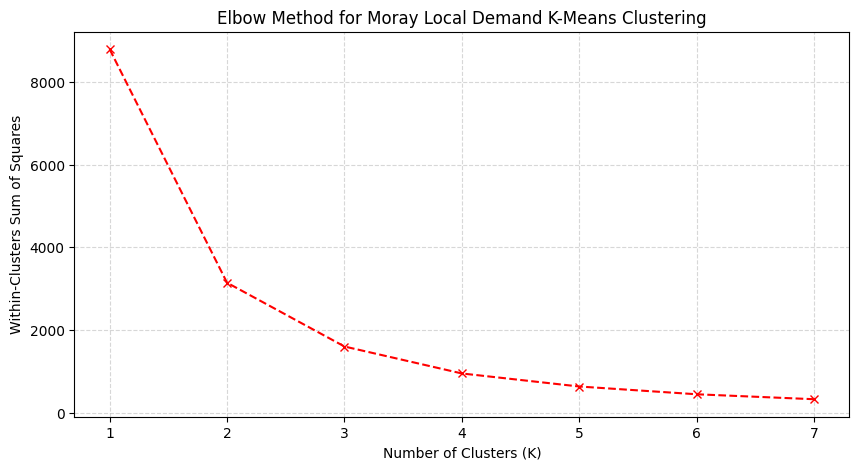

In [ ]:
#Finding the best value of "K" cluster
inertia = []
k_range = range(1,8)

for k in k_range:
  kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
  kmeans.fit(X_scaled)
  inertia.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.plot(k_range, inertia, marker='x', linestyle='--', color='red')
plt.title('Elbow Method for Moray Local Demand K-Means Clustering', fontsize=12)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Clusters Sum of Squares')
plt.xticks(k_range)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [ ]:
#Sets the model to find excatly 4 groups and execute clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df_filtered['Demand_Cluster'] = kmeans.fit_predict(X_scaled)

Text(0.5, 1.0, 'Moray Local Demand in Hours')

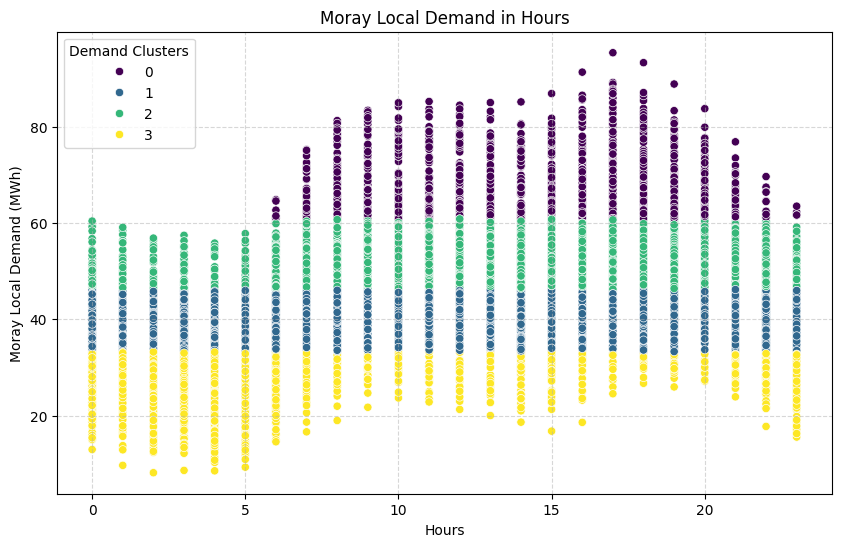

In [ ]:
#Visualise K-Means Clustering
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_filtered, x='Hour', y='Moray_Local_Demand', hue='Demand_Cluster', palette='viridis')
plt.xlabel('Hours')
plt.ylabel('Moray Local Demand (MWh)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Demand Clusters')
plt.title('Moray Local Demand in Hours')

In [ ]:
#Extracts the centroids for each cluster and transform into MW
centers_scaled = kmeans.cluster_centers_
centers_real = scaler.inverse_transform(centers_scaled)
cluster_summary = pd.DataFrame(centers_real, columns=['Average Moray  Local Demand (MW)'])
cluster_summary.index.name = 'Cluster ID'

print(cluster_summary)

            Average Moray  Local Demand (MW)
Cluster ID                                  
0                                  69.186366
1                                  39.881661
2                                  52.581067
3                                  26.568762


In [ ]:
#Dislay the operational limits of the Moray grid
range_df = df_filtered.groupby('Demand_Cluster')['Moray_Local_Demand'].agg(['min', 'max', 'mean', 'count'])
print("Demand Thresholds (per Cluster)")
print(range_df.sort_values(by='min'))

Demand Thresholds (per Cluster)
                    min      max       mean  count
Demand_Cluster                                    
3                8.1213  33.2235  26.665766   1707
1               33.2449  46.2240  39.966507   3012
2               46.2347  60.8830  52.632849   2848
0               60.8937  95.3905  69.234214   1217


In [ ]:
#Finding the total hours and percentage of the demand clusters throughout the study period

summary_demand = df_filtered['Demand_Cluster'].value_counts().to_frame('Total Hours')
summary_demand['Percentage (%)'] = (summary_demand['Total Hours']/len(df_filtered)*100).round(2)

print(summary_demand.sort_index())

                Total Hours  Percentage (%)
Demand_Cluster                             
0                      1217           13.85
1                      3012           34.29
2                      2848           32.42
3                      1707           19.43


In [ ]:
#Dictionary mapping numbers to days
map_day = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
df_filtered['Day of The Week'] = df_filtered['Days'].map(map_day)

Text(0.5, 1.0, 'Days Where Hill of Towie is at Risk - Negative Price Heatmap')

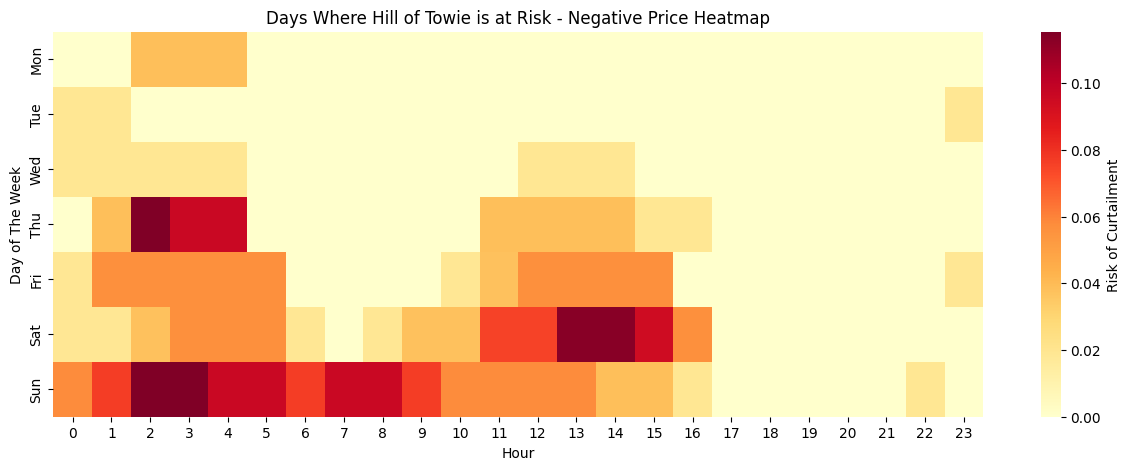

In [ ]:
#0 means in the entire 2024, a negative price never occured
#0.10 - 10% chance of the price being negative
#Grouped all ~8700 hours into 168 buckets (24 hours x 7 days). Calculate mean for each bucket
#Risk (probability) = Total hours with negative prices for that specific time / Total number of time that hour/day occured in the year

pivot = df_filtered.pivot_table(
    index='Day of The Week',
    columns='Hour',
    values='Class',
    aggfunc='mean'
)

pivot = pivot.reindex(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

plt.figure(figsize=(15,5))
sns.heatmap(pivot, cmap='YlOrRd', cbar_kws={'label':'Risk of Curtailment'})
plt.title('Days Where Hill of Towie is at Risk - Negative Price Heatmap')